# Afriat

In [1]:
ood_seed = 7

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["time_cat"] = adata.obs["time_cat"].astype(str).astype(float).astype(int).astype(str).astype("category")
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [7]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0', 'Pericentral', 'Control'),
  ('0', 'Periportal', 'Control'),
  ('12', 'Pericentral', 'Infected'),
  ('12', 'Pericentral', 'Uninfected'),
  ('12', 'Periportal', 'Infected'),
  ('12', 'Periportal', 'Uninfected'),
  ('2', 'Pericentral', 'Uninfected'),
  ('2', 'Periportal', 'Infected'),
  ('2', 'Periportal', 'Uninfected'),
  ('24', 'Pericentral', 'Infected'),
  ('24', 'Pericentral', 'Uninfected'),
  ('24', 'Periportal', 'Infected'),
  ('24', 'Periportal', 'Uninfected'),
  ('30', 'Pericentral', 'Infected'),
  ('30', 'Pericentral', 'Uninfected'),
  ('30', 'Periportal', 'Infected'),
  ('30', 'Periportal', 'Uninfected'),
  ('36', 'Pericentral', 'Infected'),
  ('36', 'Pericentral', 'Uninfected'),
  ('36', 'Periportal', 'Infected'),
  ('36', 'Periportal', 'Uninfected')],
 21)

In [8]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

('2', 'Periportal', 'Infected')


Removed datapoint: 122

train         15112
validation     3819
ood             122
Name: split, dtype: int64

In [9]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [10]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="time_cat",
    control_group="0",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['zone', 'status_control'],
)

  0%|          | 0/19053 [00:00<?, ?it/s]

 41%|████      | 7728/19053 [00:00<00:00, 77276.20it/s]

 82%|████████▏ | 15600/19053 [00:00<00:00, 78124.65it/s]

100%|██████████| 19053/19053 [00:00<00:00, 78184.25it/s]

  0%|          | 0/19053 [00:00<?, ?it/s]

100%|██████████| 19053/19053 [00:00<00:00, 1205922.53it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [11]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [12]:
model.train(max_epochs=400)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 436.38it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:09<1:01:25,  9.24s/it]

Epoch 1/400:   0%|          | 1/400 [00:09<1:01:25,  9.24s/it, v_num=1, recon=3.95e+3, r2_mean=0.209, adv_loss=3.34, acc_pert=0.245, acc_zone=0.72, acc_status_control=0.489]

Epoch 2/400:   0%|          | 1/400 [00:09<1:01:25,  9.24s/it, v_num=1, recon=3.95e+3, r2_mean=0.209, adv_loss=3.34, acc_pert=0.245, acc_zone=0.72, acc_status_control=0.489]

Epoch 2/400:   0%|          | 2/400 [00:18<1:00:15,  9.08s/it, v_num=1, recon=3.95e+3, r2_mean=0.209, adv_loss=3.34, acc_pert=0.245, acc_zone=0.72, acc_status_control=0.489]

Epoch 2/400:   0%|          | 2/400 [00:18<1:00:15,  9.08s/it, v_num=1, recon=3.24e+3, r2_mean=0.619, adv_loss=2.95, acc_pert=0.357, acc_zone=0.799, acc_status_control=0.613]

Epoch 3/400:   0%|          | 2/400 [00:18<1:00:15,  9.08s/it, v_num=1, recon=3.24e+3, r2_mean=0.619, adv_loss=2.95, acc_pert=0.357, acc_zone=0.799, acc_status_control=0.613]

Epoch 3/400:   1%|          | 3/400 [00:27<59:50,  9.04s/it, v_num=1, recon=3.24e+3, r2_mean=0.619, adv_loss=2.95, acc_pert=0.357, acc_zone=0.799, acc_status_control=0.613]  

Epoch 3/400:   1%|          | 3/400 [00:27<59:50,  9.04s/it, v_num=1, recon=3.19e+3, r2_mean=0.719, adv_loss=2.84, acc_pert=0.365, acc_zone=0.802, acc_status_control=0.62] 

Epoch 4/400:   1%|          | 3/400 [00:27<59:50,  9.04s/it, v_num=1, recon=3.19e+3, r2_mean=0.719, adv_loss=2.84, acc_pert=0.365, acc_zone=0.802, acc_status_control=0.62]

Epoch 4/400:   1%|          | 4/400 [00:36<59:35,  9.03s/it, v_num=1, recon=3.19e+3, r2_mean=0.719, adv_loss=2.84, acc_pert=0.365, acc_zone=0.802, acc_status_control=0.62]

Epoch 4/400:   1%|          | 4/400 [00:36<59:35,  9.03s/it, v_num=1, recon=3.17e+3, r2_mean=0.753, adv_loss=2.76, acc_pert=0.406, acc_zone=0.809, acc_status_control=0.618]

Epoch 5/400:   1%|          | 4/400 [00:36<59:35,  9.03s/it, v_num=1, recon=3.17e+3, r2_mean=0.753, adv_loss=2.76, acc_pert=0.406, acc_zone=0.809, acc_status_control=0.618]

Epoch 5/400:   1%|▏         | 5/400 [00:45<59:24,  9.03s/it, v_num=1, recon=3.17e+3, r2_mean=0.753, adv_loss=2.76, acc_pert=0.406, acc_zone=0.809, acc_status_control=0.618]

Epoch 5/400:   1%|▏         | 5/400 [00:45<59:24,  9.03s/it, v_num=1, recon=3.16e+3, r2_mean=0.776, adv_loss=2.55, acc_pert=0.493, acc_zone=0.823, acc_status_control=0.624]

Epoch 6/400:   1%|▏         | 5/400 [00:45<59:24,  9.03s/it, v_num=1, recon=3.16e+3, r2_mean=0.776, adv_loss=2.55, acc_pert=0.493, acc_zone=0.823, acc_status_control=0.624]

Epoch 6/400:   2%|▏         | 6/400 [00:54<59:07,  9.00s/it, v_num=1, recon=3.16e+3, r2_mean=0.776, adv_loss=2.55, acc_pert=0.493, acc_zone=0.823, acc_status_control=0.624]

Epoch 6/400:   2%|▏         | 6/400 [00:54<59:07,  9.00s/it, v_num=1, recon=3.15e+3, r2_mean=0.789, adv_loss=2.36, acc_pert=0.549, acc_zone=0.838, acc_status_control=0.637]

Epoch 7/400:   2%|▏         | 6/400 [00:54<59:07,  9.00s/it, v_num=1, recon=3.15e+3, r2_mean=0.789, adv_loss=2.36, acc_pert=0.549, acc_zone=0.838, acc_status_control=0.637]

Epoch 7/400:   2%|▏         | 7/400 [01:03<59:07,  9.03s/it, v_num=1, recon=3.15e+3, r2_mean=0.789, adv_loss=2.36, acc_pert=0.549, acc_zone=0.838, acc_status_control=0.637]

Epoch 7/400:   2%|▏         | 7/400 [01:03<59:07,  9.03s/it, v_num=1, recon=3.13e+3, r2_mean=0.797, adv_loss=2.27, acc_pert=0.559, acc_zone=0.845, acc_status_control=0.634]

Epoch 8/400:   2%|▏         | 7/400 [01:03<59:07,  9.03s/it, v_num=1, recon=3.13e+3, r2_mean=0.797, adv_loss=2.27, acc_pert=0.559, acc_zone=0.845, acc_status_control=0.634]

Epoch 8/400:   2%|▏         | 8/400 [01:12<58:50,  9.01s/it, v_num=1, recon=3.13e+3, r2_mean=0.797, adv_loss=2.27, acc_pert=0.559, acc_zone=0.845, acc_status_control=0.634]

Epoch 8/400:   2%|▏         | 8/400 [01:12<58:50,  9.01s/it, v_num=1, recon=3.13e+3, r2_mean=0.805, adv_loss=2.25, acc_pert=0.584, acc_zone=0.841, acc_status_control=0.626]

Epoch 9/400:   2%|▏         | 8/400 [01:12<58:50,  9.01s/it, v_num=1, recon=3.13e+3, r2_mean=0.805, adv_loss=2.25, acc_pert=0.584, acc_zone=0.841, acc_status_control=0.626]

Epoch 9/400:   2%|▏         | 9/400 [01:21<58:33,  8.99s/it, v_num=1, recon=3.13e+3, r2_mean=0.805, adv_loss=2.25, acc_pert=0.584, acc_zone=0.841, acc_status_control=0.626]

Epoch 9/400:   2%|▏         | 9/400 [01:21<58:33,  8.99s/it, v_num=1, recon=3.12e+3, r2_mean=0.807, adv_loss=2.22, acc_pert=0.602, acc_zone=0.846, acc_status_control=0.628]

Epoch 10/400:   2%|▏         | 9/400 [01:21<58:33,  8.99s/it, v_num=1, recon=3.12e+3, r2_mean=0.807, adv_loss=2.22, acc_pert=0.602, acc_zone=0.846, acc_status_control=0.628]


disnt_basal = 1.2308314640740912

disnt_after = 1.9001844894279303

val_r2_mean = 0.812560851914957

val_r2_var = 0.17776060820837533


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [01:34<1:07:54, 10.45s/it, v_num=1, recon=3.12e+3, r2_mean=0.807, adv_loss=2.22, acc_pert=0.602, acc_zone=0.846, acc_status_control=0.628]

Epoch 10/400:   2%|▎         | 10/400 [01:34<1:07:54, 10.45s/it, v_num=1, recon=3.11e+3, r2_mean=0.811, adv_loss=2.24, acc_pert=0.606, acc_zone=0.847, acc_status_control=0.631, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [01:34<1:07:54, 10.45s/it, v_num=1, recon=3.11e+3, r2_mean=0.811, adv_loss=2.24, acc_pert=0.606, acc_zone=0.847, acc_status_control=0.631, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [01:43<1:04:46,  9.99s/it, v_num=1, recon=3.11e+3, r2_mean=0.811, adv_loss=2.24, acc_pert=0.606, acc_zone=0.847, acc_status_control=0.631, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [01:43<1:04:46,  9.99s/it, v_num=1, recon=3.11e+3, r2_mean=0.813, adv_loss=2.17, acc_pert=0.622, acc_zone=0.85, acc_status_control=0.635, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan] 

Epoch 12/400:   3%|▎         | 11/400 [01:43<1:04:46,  9.99s/it, v_num=1, recon=3.11e+3, r2_mean=0.813, adv_loss=2.17, acc_pert=0.622, acc_zone=0.85, acc_status_control=0.635, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:52<1:02:37,  9.68s/it, v_num=1, recon=3.11e+3, r2_mean=0.813, adv_loss=2.17, acc_pert=0.622, acc_zone=0.85, acc_status_control=0.635, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:52<1:02:37,  9.68s/it, v_num=1, recon=3.11e+3, r2_mean=0.816, adv_loss=2.14, acc_pert=0.627, acc_zone=0.854, acc_status_control=0.636, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [01:52<1:02:37,  9.68s/it, v_num=1, recon=3.11e+3, r2_mean=0.816, adv_loss=2.14, acc_pert=0.627, acc_zone=0.854, acc_status_control=0.636, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [02:01<1:01:04,  9.47s/it, v_num=1, recon=3.11e+3, r2_mean=0.816, adv_loss=2.14, acc_pert=0.627, acc_zone=0.854, acc_status_control=0.636, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [02:01<1:01:04,  9.47s/it, v_num=1, recon=3.1e+3, r2_mean=0.818, adv_loss=2.16, acc_pert=0.619, acc_zone=0.853, acc_status_control=0.633, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan] 

Epoch 14/400:   3%|▎         | 13/400 [02:01<1:01:04,  9.47s/it, v_num=1, recon=3.1e+3, r2_mean=0.818, adv_loss=2.16, acc_pert=0.619, acc_zone=0.853, acc_status_control=0.633, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:10<1:00:03,  9.34s/it, v_num=1, recon=3.1e+3, r2_mean=0.818, adv_loss=2.16, acc_pert=0.619, acc_zone=0.853, acc_status_control=0.633, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:10<1:00:03,  9.34s/it, v_num=1, recon=3.09e+3, r2_mean=0.819, adv_loss=2.17, acc_pert=0.617, acc_zone=0.853, acc_status_control=0.637, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [02:10<1:00:03,  9.34s/it, v_num=1, recon=3.09e+3, r2_mean=0.819, adv_loss=2.17, acc_pert=0.617, acc_zone=0.853, acc_status_control=0.637, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:19<59:15,  9.24s/it, v_num=1, recon=3.09e+3, r2_mean=0.819, adv_loss=2.17, acc_pert=0.617, acc_zone=0.853, acc_status_control=0.637, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]  

Epoch 15/400:   4%|▍         | 15/400 [02:19<59:15,  9.24s/it, v_num=1, recon=3.09e+3, r2_mean=0.821, adv_loss=2.17, acc_pert=0.622, acc_zone=0.85, acc_status_control=0.64, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]  

Epoch 16/400:   4%|▍         | 15/400 [02:19<59:15,  9.24s/it, v_num=1, recon=3.09e+3, r2_mean=0.821, adv_loss=2.17, acc_pert=0.622, acc_zone=0.85, acc_status_control=0.64, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [02:28<58:35,  9.16s/it, v_num=1, recon=3.09e+3, r2_mean=0.821, adv_loss=2.17, acc_pert=0.622, acc_zone=0.85, acc_status_control=0.64, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [02:28<58:35,  9.16s/it, v_num=1, recon=3.09e+3, r2_mean=0.821, adv_loss=2.14, acc_pert=0.63, acc_zone=0.852, acc_status_control=0.646, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [02:28<58:35,  9.16s/it, v_num=1, recon=3.09e+3, r2_mean=0.821, adv_loss=2.14, acc_pert=0.63, acc_zone=0.852, acc_status_control=0.646, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [02:37<58:00,  9.09s/it, v_num=1, recon=3.09e+3, r2_mean=0.821, adv_loss=2.14, acc_pert=0.63, acc_zone=0.852, acc_status_control=0.646, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [02:37<58:00,  9.09s/it, v_num=1, recon=3.09e+3, r2_mean=0.821, adv_loss=2.15, acc_pert=0.625, acc_zone=0.853, acc_status_control=0.646, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [02:37<58:00,  9.09s/it, v_num=1, recon=3.09e+3, r2_mean=0.821, adv_loss=2.15, acc_pert=0.625, acc_zone=0.853, acc_status_control=0.646, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [02:46<57:37,  9.05s/it, v_num=1, recon=3.09e+3, r2_mean=0.821, adv_loss=2.15, acc_pert=0.625, acc_zone=0.853, acc_status_control=0.646, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [02:46<57:37,  9.05s/it, v_num=1, recon=3.07e+3, r2_mean=0.823, adv_loss=2.15, acc_pert=0.612, acc_zone=0.856, acc_status_control=0.647, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [02:46<57:37,  9.05s/it, v_num=1, recon=3.07e+3, r2_mean=0.823, adv_loss=2.15, acc_pert=0.612, acc_zone=0.856, acc_status_control=0.647, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [02:55<57:29,  9.05s/it, v_num=1, recon=3.07e+3, r2_mean=0.823, adv_loss=2.15, acc_pert=0.612, acc_zone=0.856, acc_status_control=0.647, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [02:55<57:29,  9.05s/it, v_num=1, recon=3.07e+3, r2_mean=0.823, adv_loss=2.15, acc_pert=0.619, acc_zone=0.851, acc_status_control=0.651, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [02:55<57:29,  9.05s/it, v_num=1, recon=3.07e+3, r2_mean=0.823, adv_loss=2.15, acc_pert=0.619, acc_zone=0.851, acc_status_control=0.651, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]


disnt_basal = 1.2363149564686906

disnt_after = 1.8927552350315138

val_r2_mean = 0.8225231781930554

val_r2_var = 0.23182235285112768


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [03:09<1:06:38, 10.52s/it, v_num=1, recon=3.07e+3, r2_mean=0.823, adv_loss=2.15, acc_pert=0.619, acc_zone=0.851, acc_status_control=0.651, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.813, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [03:09<1:06:38, 10.52s/it, v_num=1, recon=3.07e+3, r2_mean=0.825, adv_loss=2.16, acc_pert=0.617, acc_zone=0.85, acc_status_control=0.648, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [03:09<1:06:38, 10.52s/it, v_num=1, recon=3.07e+3, r2_mean=0.825, adv_loss=2.16, acc_pert=0.617, acc_zone=0.85, acc_status_control=0.648, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [03:18<1:03:35, 10.07s/it, v_num=1, recon=3.07e+3, r2_mean=0.825, adv_loss=2.16, acc_pert=0.617, acc_zone=0.85, acc_status_control=0.648, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [03:18<1:03:35, 10.07s/it, v_num=1, recon=3.06e+3, r2_mean=0.822, adv_loss=2.14, acc_pert=0.616, acc_zone=0.849, acc_status_control=0.651, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [03:18<1:03:35, 10.07s/it, v_num=1, recon=3.06e+3, r2_mean=0.822, adv_loss=2.14, acc_pert=0.616, acc_zone=0.849, acc_status_control=0.651, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [03:27<1:01:16,  9.73s/it, v_num=1, recon=3.06e+3, r2_mean=0.822, adv_loss=2.14, acc_pert=0.616, acc_zone=0.849, acc_status_control=0.651, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [03:27<1:01:16,  9.73s/it, v_num=1, recon=3.06e+3, r2_mean=0.825, adv_loss=2.11, acc_pert=0.628, acc_zone=0.855, acc_status_control=0.652, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [03:27<1:01:16,  9.73s/it, v_num=1, recon=3.06e+3, r2_mean=0.825, adv_loss=2.11, acc_pert=0.628, acc_zone=0.855, acc_status_control=0.652, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [03:36<59:49,  9.52s/it, v_num=1, recon=3.06e+3, r2_mean=0.825, adv_loss=2.11, acc_pert=0.628, acc_zone=0.855, acc_status_control=0.652, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]  

Epoch 23/400:   6%|▌         | 23/400 [03:36<59:49,  9.52s/it, v_num=1, recon=3.05e+3, r2_mean=0.824, adv_loss=2.12, acc_pert=0.624, acc_zone=0.85, acc_status_control=0.648, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan] 

Epoch 24/400:   6%|▌         | 23/400 [03:36<59:49,  9.52s/it, v_num=1, recon=3.05e+3, r2_mean=0.824, adv_loss=2.12, acc_pert=0.624, acc_zone=0.85, acc_status_control=0.648, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [03:45<58:48,  9.38s/it, v_num=1, recon=3.05e+3, r2_mean=0.824, adv_loss=2.12, acc_pert=0.624, acc_zone=0.85, acc_status_control=0.648, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [03:45<58:48,  9.38s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=2.12, acc_pert=0.622, acc_zone=0.852, acc_status_control=0.65, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [03:45<58:48,  9.38s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=2.12, acc_pert=0.622, acc_zone=0.852, acc_status_control=0.65, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [03:54<57:48,  9.25s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=2.12, acc_pert=0.622, acc_zone=0.852, acc_status_control=0.65, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [03:54<57:48,  9.25s/it, v_num=1, recon=3.06e+3, r2_mean=0.827, adv_loss=2.13, acc_pert=0.626, acc_zone=0.844, acc_status_control=0.651, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [03:54<57:48,  9.25s/it, v_num=1, recon=3.06e+3, r2_mean=0.827, adv_loss=2.13, acc_pert=0.626, acc_zone=0.844, acc_status_control=0.651, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [04:03<57:15,  9.19s/it, v_num=1, recon=3.06e+3, r2_mean=0.827, adv_loss=2.13, acc_pert=0.626, acc_zone=0.844, acc_status_control=0.651, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [04:03<57:15,  9.19s/it, v_num=1, recon=3.04e+3, r2_mean=0.824, adv_loss=2.14, acc_pert=0.617, acc_zone=0.849, acc_status_control=0.655, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [04:03<57:15,  9.19s/it, v_num=1, recon=3.04e+3, r2_mean=0.824, adv_loss=2.14, acc_pert=0.617, acc_zone=0.849, acc_status_control=0.655, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [04:12<56:51,  9.15s/it, v_num=1, recon=3.04e+3, r2_mean=0.824, adv_loss=2.14, acc_pert=0.617, acc_zone=0.849, acc_status_control=0.655, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [04:12<56:51,  9.15s/it, v_num=1, recon=3.05e+3, r2_mean=0.827, adv_loss=2.13, acc_pert=0.615, acc_zone=0.847, acc_status_control=0.65, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan] 

Epoch 28/400:   7%|▋         | 27/400 [04:12<56:51,  9.15s/it, v_num=1, recon=3.05e+3, r2_mean=0.827, adv_loss=2.13, acc_pert=0.615, acc_zone=0.847, acc_status_control=0.65, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [04:21<56:22,  9.09s/it, v_num=1, recon=3.05e+3, r2_mean=0.827, adv_loss=2.13, acc_pert=0.615, acc_zone=0.847, acc_status_control=0.65, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [04:21<56:22,  9.09s/it, v_num=1, recon=3.04e+3, r2_mean=0.826, adv_loss=2.13, acc_pert=0.611, acc_zone=0.85, acc_status_control=0.658, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [04:21<56:22,  9.09s/it, v_num=1, recon=3.04e+3, r2_mean=0.826, adv_loss=2.13, acc_pert=0.611, acc_zone=0.85, acc_status_control=0.658, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [04:30<55:53,  9.04s/it, v_num=1, recon=3.04e+3, r2_mean=0.826, adv_loss=2.13, acc_pert=0.611, acc_zone=0.85, acc_status_control=0.658, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [04:30<55:53,  9.04s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=2.14, acc_pert=0.61, acc_zone=0.847, acc_status_control=0.658, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [04:30<55:53,  9.04s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=2.14, acc_pert=0.61, acc_zone=0.847, acc_status_control=0.658, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]


disnt_basal = 1.2282256403101277

disnt_after = 1.8902071529163287

val_r2_mean = 0.8323126127291808

val_r2_var = 0.24693846413283188


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [04:44<1:04:52, 10.52s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=2.14, acc_pert=0.61, acc_zone=0.847, acc_status_control=0.658, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.823, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [04:44<1:04:52, 10.52s/it, v_num=1, recon=3.04e+3, r2_mean=0.83, adv_loss=2.16, acc_pert=0.605, acc_zone=0.845, acc_status_control=0.657, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [04:44<1:04:52, 10.52s/it, v_num=1, recon=3.04e+3, r2_mean=0.83, adv_loss=2.16, acc_pert=0.605, acc_zone=0.845, acc_status_control=0.657, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [04:53<1:01:55, 10.07s/it, v_num=1, recon=3.04e+3, r2_mean=0.83, adv_loss=2.16, acc_pert=0.605, acc_zone=0.845, acc_status_control=0.657, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [04:53<1:01:55, 10.07s/it, v_num=1, recon=3.03e+3, r2_mean=0.829, adv_loss=2.17, acc_pert=0.6, acc_zone=0.847, acc_status_control=0.648, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan] 

Epoch 32/400:   8%|▊         | 31/400 [04:53<1:01:55, 10.07s/it, v_num=1, recon=3.03e+3, r2_mean=0.829, adv_loss=2.17, acc_pert=0.6, acc_zone=0.847, acc_status_control=0.648, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [05:02<59:52,  9.76s/it, v_num=1, recon=3.03e+3, r2_mean=0.829, adv_loss=2.17, acc_pert=0.6, acc_zone=0.847, acc_status_control=0.648, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]  

Epoch 32/400:   8%|▊         | 32/400 [05:02<59:52,  9.76s/it, v_num=1, recon=3.04e+3, r2_mean=0.83, adv_loss=2.16, acc_pert=0.602, acc_zone=0.845, acc_status_control=0.656, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [05:02<59:52,  9.76s/it, v_num=1, recon=3.04e+3, r2_mean=0.83, adv_loss=2.16, acc_pert=0.602, acc_zone=0.845, acc_status_control=0.656, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [05:11<58:10,  9.51s/it, v_num=1, recon=3.04e+3, r2_mean=0.83, adv_loss=2.16, acc_pert=0.602, acc_zone=0.845, acc_status_control=0.656, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [05:11<58:10,  9.51s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=2.17, acc_pert=0.603, acc_zone=0.847, acc_status_control=0.651, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [05:11<58:10,  9.51s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=2.17, acc_pert=0.603, acc_zone=0.847, acc_status_control=0.651, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [05:20<56:58,  9.34s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=2.17, acc_pert=0.603, acc_zone=0.847, acc_status_control=0.651, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [05:20<56:58,  9.34s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=2.17, acc_pert=0.599, acc_zone=0.848, acc_status_control=0.653, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [05:20<56:58,  9.34s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=2.17, acc_pert=0.599, acc_zone=0.848, acc_status_control=0.653, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [05:29<55:58,  9.20s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=2.17, acc_pert=0.599, acc_zone=0.848, acc_status_control=0.653, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [05:29<55:58,  9.20s/it, v_num=1, recon=3.02e+3, r2_mean=0.832, adv_loss=2.18, acc_pert=0.596, acc_zone=0.844, acc_status_control=0.649, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [05:29<55:58,  9.20s/it, v_num=1, recon=3.02e+3, r2_mean=0.832, adv_loss=2.18, acc_pert=0.596, acc_zone=0.844, acc_status_control=0.649, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [05:38<55:19,  9.12s/it, v_num=1, recon=3.02e+3, r2_mean=0.832, adv_loss=2.18, acc_pert=0.596, acc_zone=0.844, acc_status_control=0.649, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [05:38<55:19,  9.12s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=2.17, acc_pert=0.604, acc_zone=0.847, acc_status_control=0.655, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan] 

Epoch 37/400:   9%|▉         | 36/400 [05:38<55:19,  9.12s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=2.17, acc_pert=0.604, acc_zone=0.847, acc_status_control=0.655, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [05:47<55:00,  9.09s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=2.17, acc_pert=0.604, acc_zone=0.847, acc_status_control=0.655, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [05:47<55:00,  9.09s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.16, acc_pert=0.606, acc_zone=0.846, acc_status_control=0.65, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [05:47<55:00,  9.09s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.16, acc_pert=0.606, acc_zone=0.846, acc_status_control=0.65, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [05:56<54:39,  9.06s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.16, acc_pert=0.606, acc_zone=0.846, acc_status_control=0.65, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [05:56<54:39,  9.06s/it, v_num=1, recon=3.01e+3, r2_mean=0.832, adv_loss=2.18, acc_pert=0.595, acc_zone=0.843, acc_status_control=0.654, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [05:56<54:39,  9.06s/it, v_num=1, recon=3.01e+3, r2_mean=0.832, adv_loss=2.18, acc_pert=0.595, acc_zone=0.843, acc_status_control=0.654, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [06:05<54:25,  9.05s/it, v_num=1, recon=3.01e+3, r2_mean=0.832, adv_loss=2.18, acc_pert=0.595, acc_zone=0.843, acc_status_control=0.654, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [06:05<54:25,  9.05s/it, v_num=1, recon=3.01e+3, r2_mean=0.829, adv_loss=2.17, acc_pert=0.6, acc_zone=0.845, acc_status_control=0.651, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]  

Epoch 40/400:  10%|▉         | 39/400 [06:05<54:25,  9.05s/it, v_num=1, recon=3.01e+3, r2_mean=0.829, adv_loss=2.17, acc_pert=0.6, acc_zone=0.845, acc_status_control=0.651, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.2143777109904161

disnt_after = 1.8770026877175028

val_r2_mean = 0.8322026320899714

val_r2_var = 0.2598651226471776


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [06:19<1:03:19, 10.55s/it, v_num=1, recon=3.01e+3, r2_mean=0.829, adv_loss=2.17, acc_pert=0.6, acc_zone=0.845, acc_status_control=0.651, val_recon=3.04e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [06:19<1:03:19, 10.55s/it, v_num=1, recon=3.01e+3, r2_mean=0.832, adv_loss=2.17, acc_pert=0.603, acc_zone=0.842, acc_status_control=0.655, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [06:19<1:03:19, 10.55s/it, v_num=1, recon=3.01e+3, r2_mean=0.832, adv_loss=2.17, acc_pert=0.603, acc_zone=0.842, acc_status_control=0.655, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [06:28<1:00:15, 10.07s/it, v_num=1, recon=3.01e+3, r2_mean=0.832, adv_loss=2.17, acc_pert=0.603, acc_zone=0.842, acc_status_control=0.655, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [06:28<1:00:15, 10.07s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.17, acc_pert=0.603, acc_zone=0.845, acc_status_control=0.654, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]   

Epoch 42/400:  10%|█         | 41/400 [06:28<1:00:15, 10.07s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.17, acc_pert=0.603, acc_zone=0.845, acc_status_control=0.654, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [06:37<58:18,  9.77s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.17, acc_pert=0.603, acc_zone=0.845, acc_status_control=0.654, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]  

Epoch 42/400:  10%|█         | 42/400 [06:37<58:18,  9.77s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.18, acc_pert=0.598, acc_zone=0.837, acc_status_control=0.654, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [06:37<58:18,  9.77s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.18, acc_pert=0.598, acc_zone=0.837, acc_status_control=0.654, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [06:46<56:39,  9.52s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.18, acc_pert=0.598, acc_zone=0.837, acc_status_control=0.654, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [06:46<56:39,  9.52s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=2.17, acc_pert=0.603, acc_zone=0.841, acc_status_control=0.652, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]   

Epoch 44/400:  11%|█         | 43/400 [06:46<56:39,  9.52s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=2.17, acc_pert=0.603, acc_zone=0.841, acc_status_control=0.652, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [06:55<55:32,  9.36s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=2.17, acc_pert=0.603, acc_zone=0.841, acc_status_control=0.652, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [06:55<55:32,  9.36s/it, v_num=1, recon=3e+3, r2_mean=0.83, adv_loss=2.19, acc_pert=0.59, acc_zone=0.84, acc_status_control=0.654, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]   

Epoch 45/400:  11%|█         | 44/400 [06:55<55:32,  9.36s/it, v_num=1, recon=3e+3, r2_mean=0.83, adv_loss=2.19, acc_pert=0.59, acc_zone=0.84, acc_status_control=0.654, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [07:04<54:58,  9.29s/it, v_num=1, recon=3e+3, r2_mean=0.83, adv_loss=2.19, acc_pert=0.59, acc_zone=0.84, acc_status_control=0.654, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [07:04<54:58,  9.29s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.19, acc_pert=0.589, acc_zone=0.844, acc_status_control=0.653, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [07:04<54:58,  9.29s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.19, acc_pert=0.589, acc_zone=0.844, acc_status_control=0.653, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [07:13<54:27,  9.23s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.19, acc_pert=0.589, acc_zone=0.844, acc_status_control=0.653, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [07:13<54:27,  9.23s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=2.2, acc_pert=0.585, acc_zone=0.841, acc_status_control=0.651, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan] 

Epoch 47/400:  12%|█▏        | 46/400 [07:13<54:27,  9.23s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=2.2, acc_pert=0.585, acc_zone=0.841, acc_status_control=0.651, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [07:22<53:50,  9.15s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=2.2, acc_pert=0.585, acc_zone=0.841, acc_status_control=0.651, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [07:22<53:50,  9.15s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=2.19, acc_pert=0.593, acc_zone=0.839, acc_status_control=0.653, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [07:22<53:50,  9.15s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=2.19, acc_pert=0.593, acc_zone=0.839, acc_status_control=0.653, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [07:31<53:16,  9.08s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=2.19, acc_pert=0.593, acc_zone=0.839, acc_status_control=0.653, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [07:31<53:16,  9.08s/it, v_num=1, recon=2.99e+3, r2_mean=0.831, adv_loss=2.2, acc_pert=0.586, acc_zone=0.84, acc_status_control=0.655, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [07:31<53:16,  9.08s/it, v_num=1, recon=2.99e+3, r2_mean=0.831, adv_loss=2.2, acc_pert=0.586, acc_zone=0.84, acc_status_control=0.655, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [07:40<53:03,  9.07s/it, v_num=1, recon=2.99e+3, r2_mean=0.831, adv_loss=2.2, acc_pert=0.586, acc_zone=0.84, acc_status_control=0.655, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [07:40<53:03,  9.07s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.21, acc_pert=0.582, acc_zone=0.842, acc_status_control=0.658, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [07:40<53:03,  9.07s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.21, acc_pert=0.582, acc_zone=0.842, acc_status_control=0.658, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.213959092231007

disnt_after = 1.8770975594325763

val_r2_mean = 0.8310294356696033

val_r2_var = 0.26600437467487065

Epoch 50/400:  12%|█▎        | 50/400 [07:54<1:01:38, 10.57s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.21, acc_pert=0.582, acc_zone=0.842, acc_status_control=0.658, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [07:54<1:01:38, 10.57s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.2, acc_pert=0.587, acc_zone=0.841, acc_status_control=0.652, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]    

Epoch 51/400:  12%|█▎        | 50/400 [07:54<1:01:38, 10.57s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.2, acc_pert=0.587, acc_zone=0.841, acc_status_control=0.652, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [08:04<1:00:55, 10.47s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.2, acc_pert=0.587, acc_zone=0.841, acc_status_control=0.652, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [08:04<1:00:55, 10.47s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.2, acc_pert=0.592, acc_zone=0.838, acc_status_control=0.656, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [08:04<1:00:55, 10.47s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.2, acc_pert=0.592, acc_zone=0.838, acc_status_control=0.656, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [08:15<1:00:22, 10.41s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.2, acc_pert=0.592, acc_zone=0.838, acc_status_control=0.656, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [08:15<1:00:22, 10.41s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.23, acc_pert=0.576, acc_zone=0.839, acc_status_control=0.652, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [08:15<1:00:22, 10.41s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.23, acc_pert=0.576, acc_zone=0.839, acc_status_control=0.652, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [08:25<1:00:13, 10.41s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.23, acc_pert=0.576, acc_zone=0.839, acc_status_control=0.652, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [08:25<1:00:13, 10.41s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=2.21, acc_pert=0.585, acc_zone=0.843, acc_status_control=0.653, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [08:25<1:00:13, 10.41s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=2.21, acc_pert=0.585, acc_zone=0.843, acc_status_control=0.653, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [08:35<59:52, 10.38s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=2.21, acc_pert=0.585, acc_zone=0.843, acc_status_control=0.653, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]  

Epoch 54/400:  14%|█▎        | 54/400 [08:35<59:52, 10.38s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.579, acc_zone=0.837, acc_status_control=0.656, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [08:35<59:52, 10.38s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.579, acc_zone=0.837, acc_status_control=0.656, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [08:46<59:32, 10.35s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.22, acc_pert=0.579, acc_zone=0.837, acc_status_control=0.656, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [08:46<59:32, 10.35s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=2.21, acc_pert=0.584, acc_zone=0.838, acc_status_control=0.657, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [08:46<59:32, 10.35s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=2.21, acc_pert=0.584, acc_zone=0.838, acc_status_control=0.657, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [08:56<59:43, 10.42s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=2.21, acc_pert=0.584, acc_zone=0.838, acc_status_control=0.657, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [08:56<59:43, 10.42s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.22, acc_pert=0.578, acc_zone=0.841, acc_status_control=0.655, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [08:56<59:43, 10.42s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.22, acc_pert=0.578, acc_zone=0.841, acc_status_control=0.655, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [09:07<59:23, 10.39s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.22, acc_pert=0.578, acc_zone=0.841, acc_status_control=0.655, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [09:07<59:23, 10.39s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.22, acc_pert=0.588, acc_zone=0.838, acc_status_control=0.655, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [09:07<59:23, 10.39s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.22, acc_pert=0.588, acc_zone=0.838, acc_status_control=0.655, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [09:17<59:10, 10.38s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.22, acc_pert=0.588, acc_zone=0.838, acc_status_control=0.655, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [09:17<59:10, 10.38s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.23, acc_pert=0.574, acc_zone=0.842, acc_status_control=0.653, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [09:17<59:10, 10.38s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.23, acc_pert=0.574, acc_zone=0.842, acc_status_control=0.653, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [09:27<58:54, 10.36s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.23, acc_pert=0.574, acc_zone=0.842, acc_status_control=0.653, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [09:27<58:54, 10.36s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=2.23, acc_pert=0.579, acc_zone=0.835, acc_status_control=0.655, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [09:27<58:54, 10.36s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=2.23, acc_pert=0.579, acc_zone=0.835, acc_status_control=0.655, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.2153886542967944

disnt_after = 1.8805888433641529

val_r2_mean = 0.8334873589094852

val_r2_var = 0.27837940367847985


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [09:43<1:07:16, 11.87s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=2.23, acc_pert=0.579, acc_zone=0.835, acc_status_control=0.655, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [09:43<1:07:16, 11.87s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.23, acc_pert=0.582, acc_zone=0.838, acc_status_control=0.65, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [09:43<1:07:16, 11.87s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.23, acc_pert=0.582, acc_zone=0.838, acc_status_control=0.65, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [09:52<1:02:21, 11.04s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.23, acc_pert=0.582, acc_zone=0.838, acc_status_control=0.65, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [09:52<1:02:21, 11.04s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.23, acc_pert=0.581, acc_zone=0.839, acc_status_control=0.654, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [09:52<1:02:21, 11.04s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.23, acc_pert=0.581, acc_zone=0.839, acc_status_control=0.654, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [10:01<58:41, 10.42s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.23, acc_pert=0.581, acc_zone=0.839, acc_status_control=0.654, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]  

Epoch 62/400:  16%|█▌        | 62/400 [10:01<58:41, 10.42s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.24, acc_pert=0.576, acc_zone=0.834, acc_status_control=0.652, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [10:01<58:41, 10.42s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.24, acc_pert=0.576, acc_zone=0.834, acc_status_control=0.652, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [10:10<56:08,  9.99s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.24, acc_pert=0.576, acc_zone=0.834, acc_status_control=0.652, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [10:10<56:08,  9.99s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.25, acc_pert=0.578, acc_zone=0.836, acc_status_control=0.65, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan] 

Epoch 64/400:  16%|█▌        | 63/400 [10:10<56:08,  9.99s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.25, acc_pert=0.578, acc_zone=0.836, acc_status_control=0.65, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [10:19<54:08,  9.67s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.25, acc_pert=0.578, acc_zone=0.836, acc_status_control=0.65, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [10:19<54:08,  9.67s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.23, acc_pert=0.571, acc_zone=0.836, acc_status_control=0.655, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [10:19<54:08,  9.67s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.23, acc_pert=0.571, acc_zone=0.836, acc_status_control=0.655, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [10:28<52:46,  9.45s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.23, acc_pert=0.571, acc_zone=0.836, acc_status_control=0.655, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [10:28<52:46,  9.45s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.25, acc_pert=0.57, acc_zone=0.836, acc_status_control=0.652, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan] 

Epoch 66/400:  16%|█▋        | 65/400 [10:28<52:46,  9.45s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.25, acc_pert=0.57, acc_zone=0.836, acc_status_control=0.652, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [10:37<51:53,  9.32s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.25, acc_pert=0.57, acc_zone=0.836, acc_status_control=0.652, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [10:37<51:53,  9.32s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.569, acc_zone=0.833, acc_status_control=0.652, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [10:37<51:53,  9.32s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.569, acc_zone=0.833, acc_status_control=0.652, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [10:46<51:05,  9.21s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.569, acc_zone=0.833, acc_status_control=0.652, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [10:46<51:05,  9.21s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.571, acc_zone=0.829, acc_status_control=0.649, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [10:46<51:05,  9.21s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.571, acc_zone=0.829, acc_status_control=0.649, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [10:54<50:32,  9.13s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.571, acc_zone=0.829, acc_status_control=0.649, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [10:54<50:32,  9.13s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.568, acc_zone=0.839, acc_status_control=0.652, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [10:54<50:32,  9.13s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.568, acc_zone=0.839, acc_status_control=0.652, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [11:03<50:07,  9.09s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.568, acc_zone=0.839, acc_status_control=0.652, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [11:03<50:07,  9.09s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.566, acc_zone=0.834, acc_status_control=0.652, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [11:03<50:07,  9.09s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.566, acc_zone=0.834, acc_status_control=0.652, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.204899073070451

disnt_after = 1.8797721369754596

val_r2_mean = 0.8354067081603473

val_r2_var = 0.2747887898220122


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [11:18<58:13, 10.59s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.566, acc_zone=0.834, acc_status_control=0.652, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [11:18<58:13, 10.59s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.24, acc_pert=0.571, acc_zone=0.837, acc_status_control=0.653, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan] 

Epoch 71/400:  18%|█▊        | 70/400 [11:18<58:13, 10.59s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.24, acc_pert=0.571, acc_zone=0.837, acc_status_control=0.653, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [11:26<55:13, 10.07s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.24, acc_pert=0.571, acc_zone=0.837, acc_status_control=0.653, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [11:26<55:13, 10.07s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.25, acc_pert=0.568, acc_zone=0.833, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan] 

Epoch 72/400:  18%|█▊        | 71/400 [11:26<55:13, 10.07s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.25, acc_pert=0.568, acc_zone=0.833, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [11:35<53:17,  9.75s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.25, acc_pert=0.568, acc_zone=0.833, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [11:35<53:17,  9.75s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.24, acc_pert=0.575, acc_zone=0.838, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [11:35<53:17,  9.75s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.24, acc_pert=0.575, acc_zone=0.838, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [11:44<51:48,  9.51s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.24, acc_pert=0.575, acc_zone=0.838, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [11:44<51:48,  9.51s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.57, acc_zone=0.833, acc_status_control=0.653, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan] 

Epoch 74/400:  18%|█▊        | 73/400 [11:44<51:48,  9.51s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.57, acc_zone=0.833, acc_status_control=0.653, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [11:53<50:47,  9.35s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.57, acc_zone=0.833, acc_status_control=0.653, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [11:53<50:47,  9.35s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.26, acc_pert=0.567, acc_zone=0.833, acc_status_control=0.651, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [11:53<50:47,  9.35s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.26, acc_pert=0.567, acc_zone=0.833, acc_status_control=0.651, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [12:02<50:01,  9.23s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.26, acc_pert=0.567, acc_zone=0.833, acc_status_control=0.651, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [12:02<50:01,  9.23s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.25, acc_pert=0.568, acc_zone=0.838, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan] 

Epoch 76/400:  19%|█▉        | 75/400 [12:02<50:01,  9.23s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.25, acc_pert=0.568, acc_zone=0.838, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [12:11<49:23,  9.15s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.25, acc_pert=0.568, acc_zone=0.838, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [12:11<49:23,  9.15s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.571, acc_zone=0.834, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [12:11<49:23,  9.15s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.571, acc_zone=0.834, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [12:20<49:03,  9.11s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.571, acc_zone=0.834, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [12:20<49:03,  9.11s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.26, acc_pert=0.568, acc_zone=0.839, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [12:20<49:03,  9.11s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.26, acc_pert=0.568, acc_zone=0.839, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [12:29<48:37,  9.06s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.26, acc_pert=0.568, acc_zone=0.839, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [12:29<48:37,  9.06s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.563, acc_zone=0.831, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [12:29<48:37,  9.06s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.563, acc_zone=0.831, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [12:38<48:20,  9.04s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.563, acc_zone=0.831, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [12:38<48:20,  9.04s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.559, acc_zone=0.831, acc_status_control=0.653, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [12:38<48:20,  9.04s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.559, acc_zone=0.831, acc_status_control=0.653, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]


disnt_basal = 1.2065860804940791

disnt_after = 1.882296336840818

val_r2_mean = 0.8304156106953601

val_r2_var = 0.2876431435577321


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [12:52<56:22, 10.57s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.559, acc_zone=0.831, acc_status_control=0.653, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [12:52<56:22, 10.57s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.562, acc_zone=0.832, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [12:52<56:22, 10.57s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.562, acc_zone=0.832, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [13:01<53:39, 10.09s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.562, acc_zone=0.832, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [13:01<53:39, 10.09s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.566, acc_zone=0.829, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [13:01<53:39, 10.09s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.566, acc_zone=0.829, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [13:10<51:39,  9.75s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.566, acc_zone=0.829, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [13:10<51:39,  9.75s/it, v_num=1, recon=2.93e+3, r2_mean=0.834, adv_loss=2.27, acc_pert=0.562, acc_zone=0.83, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]  

Epoch 83/400:  20%|██        | 82/400 [13:10<51:39,  9.75s/it, v_num=1, recon=2.93e+3, r2_mean=0.834, adv_loss=2.27, acc_pert=0.562, acc_zone=0.83, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [13:19<50:23,  9.54s/it, v_num=1, recon=2.93e+3, r2_mean=0.834, adv_loss=2.27, acc_pert=0.562, acc_zone=0.83, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [13:19<50:23,  9.54s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.27, acc_pert=0.561, acc_zone=0.833, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [13:19<50:23,  9.54s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.27, acc_pert=0.561, acc_zone=0.833, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [13:28<49:18,  9.36s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.27, acc_pert=0.561, acc_zone=0.833, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [13:28<49:18,  9.36s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.56, acc_zone=0.832, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan] 

Epoch 85/400:  21%|██        | 84/400 [13:28<49:18,  9.36s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.56, acc_zone=0.832, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [13:37<48:33,  9.25s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.56, acc_zone=0.832, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [13:37<48:33,  9.25s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.565, acc_zone=0.834, acc_status_control=0.645, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [13:37<48:33,  9.25s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.565, acc_zone=0.834, acc_status_control=0.645, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [13:46<47:50,  9.14s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.565, acc_zone=0.834, acc_status_control=0.645, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [13:46<47:50,  9.14s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.564, acc_zone=0.831, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [13:46<47:50,  9.14s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.564, acc_zone=0.831, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [13:55<47:31,  9.11s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.564, acc_zone=0.831, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [13:55<47:31,  9.11s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.28, acc_pert=0.554, acc_zone=0.83, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan] 

Epoch 88/400:  22%|██▏       | 87/400 [13:55<47:31,  9.11s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.28, acc_pert=0.554, acc_zone=0.83, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [14:04<47:24,  9.12s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.28, acc_pert=0.554, acc_zone=0.83, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [14:04<47:24,  9.12s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.568, acc_zone=0.83, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [14:04<47:24,  9.12s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.568, acc_zone=0.83, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [14:13<47:04,  9.08s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.568, acc_zone=0.83, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [14:13<47:04,  9.08s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.559, acc_zone=0.832, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [14:13<47:04,  9.08s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.559, acc_zone=0.832, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.202926966606588

disnt_after = 1.872034396045553

val_r2_mean = 0.8330936414117072

val_r2_var = 0.2976728240193281

Epoch 90/400:  22%|██▎       | 90/400 [14:27<54:48, 10.61s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.559, acc_zone=0.832, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [14:27<54:48, 10.61s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.28, acc_pert=0.561, acc_zone=0.834, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [14:27<54:48, 10.61s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.28, acc_pert=0.561, acc_zone=0.834, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [14:36<52:08, 10.12s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.28, acc_pert=0.561, acc_zone=0.834, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [14:36<52:08, 10.12s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.56, acc_zone=0.831, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan] 

Epoch 92/400:  23%|██▎       | 91/400 [14:36<52:08, 10.12s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.56, acc_zone=0.831, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [14:45<50:09,  9.77s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.56, acc_zone=0.831, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [14:45<50:09,  9.77s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.553, acc_zone=0.831, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [14:45<50:09,  9.77s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.553, acc_zone=0.831, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [14:55<48:59,  9.57s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.553, acc_zone=0.831, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [14:55<48:59,  9.57s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.561, acc_zone=0.832, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [14:55<48:59,  9.57s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.561, acc_zone=0.832, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [15:04<48:03,  9.42s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.561, acc_zone=0.832, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [15:04<48:03,  9.42s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.557, acc_zone=0.832, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [15:04<48:03,  9.42s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.557, acc_zone=0.832, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [15:12<47:05,  9.26s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.557, acc_zone=0.832, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [15:12<47:05,  9.26s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.27, acc_pert=0.562, acc_zone=0.828, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan] 

Epoch 96/400:  24%|██▍       | 95/400 [15:12<47:05,  9.26s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.27, acc_pert=0.562, acc_zone=0.828, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [15:21<46:28,  9.17s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.27, acc_pert=0.562, acc_zone=0.828, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [15:21<46:28,  9.17s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.557, acc_zone=0.834, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [15:21<46:28,  9.17s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.557, acc_zone=0.834, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [15:30<46:07,  9.13s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.557, acc_zone=0.834, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [15:30<46:07,  9.13s/it, v_num=1, recon=2.92e+3, r2_mean=0.835, adv_loss=2.27, acc_pert=0.564, acc_zone=0.83, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan] 

Epoch 98/400:  24%|██▍       | 97/400 [15:30<46:07,  9.13s/it, v_num=1, recon=2.92e+3, r2_mean=0.835, adv_loss=2.27, acc_pert=0.564, acc_zone=0.83, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [15:39<45:42,  9.08s/it, v_num=1, recon=2.92e+3, r2_mean=0.835, adv_loss=2.27, acc_pert=0.564, acc_zone=0.83, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [15:39<45:42,  9.08s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.556, acc_zone=0.833, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [15:39<45:42,  9.08s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.556, acc_zone=0.833, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [15:49<45:32,  9.08s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.556, acc_zone=0.833, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [15:49<45:32,  9.08s/it, v_num=1, recon=2.91e+3, r2_mean=0.835, adv_loss=2.29, acc_pert=0.552, acc_zone=0.828, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [15:49<45:32,  9.08s/it, v_num=1, recon=2.91e+3, r2_mean=0.835, adv_loss=2.29, acc_pert=0.552, acc_zone=0.828, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.200967672165975

disnt_after = 1.8744035958516376

val_r2_mean = 0.8314033190245017

val_r2_var = 0.2956941193051738

Epoch 100/400:  25%|██▌       | 100/400 [16:03<53:02, 10.61s/it, v_num=1, recon=2.91e+3, r2_mean=0.835, adv_loss=2.29, acc_pert=0.552, acc_zone=0.828, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [16:03<53:02, 10.61s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.555, acc_zone=0.834, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [16:03<53:02, 10.61s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.555, acc_zone=0.834, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [16:12<50:19, 10.10s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.555, acc_zone=0.834, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [16:12<50:19, 10.10s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.555, acc_zone=0.832, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan] 

Epoch 102/400:  25%|██▌       | 101/400 [16:12<50:19, 10.10s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.555, acc_zone=0.832, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [16:21<48:23,  9.74s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.555, acc_zone=0.832, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [16:21<48:23,  9.74s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.55, acc_zone=0.834, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan] 

Epoch 103/400:  26%|██▌       | 102/400 [16:21<48:23,  9.74s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.55, acc_zone=0.834, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [16:29<46:57,  9.49s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.55, acc_zone=0.834, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [16:29<46:57,  9.49s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.548, acc_zone=0.831, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [16:29<46:57,  9.49s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.548, acc_zone=0.831, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [16:38<45:59,  9.32s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.548, acc_zone=0.831, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [16:38<45:59,  9.32s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.563, acc_zone=0.833, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan] 

Epoch 105/400:  26%|██▌       | 104/400 [16:38<45:59,  9.32s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.563, acc_zone=0.833, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [16:47<45:18,  9.22s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.563, acc_zone=0.833, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [16:47<45:18,  9.22s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.551, acc_zone=0.833, acc_status_control=0.648, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [16:47<45:18,  9.22s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.551, acc_zone=0.833, acc_status_control=0.648, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [16:56<44:47,  9.14s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.551, acc_zone=0.833, acc_status_control=0.648, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [16:56<44:47,  9.14s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.559, acc_zone=0.832, acc_status_control=0.649, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [16:56<44:47,  9.14s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.559, acc_zone=0.832, acc_status_control=0.649, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [17:05<44:26,  9.10s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.559, acc_zone=0.832, acc_status_control=0.649, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [17:05<44:26,  9.10s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.559, acc_zone=0.834, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan] 

Epoch 108/400:  27%|██▋       | 107/400 [17:05<44:26,  9.10s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.559, acc_zone=0.834, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [17:14<44:09,  9.08s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.559, acc_zone=0.834, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [17:14<44:09,  9.08s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.555, acc_zone=0.832, acc_status_control=0.653, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [17:14<44:09,  9.08s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.555, acc_zone=0.832, acc_status_control=0.653, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [17:25<46:01,  9.49s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.555, acc_zone=0.832, acc_status_control=0.653, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [17:25<46:01,  9.49s/it, v_num=1, recon=2.9e+3, r2_mean=0.834, adv_loss=2.28, acc_pert=0.556, acc_zone=0.833, acc_status_control=0.653, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan] 

Epoch 110/400:  27%|██▋       | 109/400 [17:25<46:01,  9.49s/it, v_num=1, recon=2.9e+3, r2_mean=0.834, adv_loss=2.28, acc_pert=0.556, acc_zone=0.833, acc_status_control=0.653, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.2013454286596763

disnt_after = 1.8712178725670194

val_r2_mean = 0.8352278926607659

val_r2_var = 0.29456673282946194

Epoch 110/400:  28%|██▊       | 110/400 [17:40<53:43, 11.12s/it, v_num=1, recon=2.9e+3, r2_mean=0.834, adv_loss=2.28, acc_pert=0.556, acc_zone=0.833, acc_status_control=0.653, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [17:40<53:43, 11.12s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.558, acc_zone=0.835, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [17:40<53:43, 11.12s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.558, acc_zone=0.835, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [17:49<50:27, 10.48s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.558, acc_zone=0.835, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [17:49<50:27, 10.48s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.554, acc_zone=0.834, acc_status_control=0.648, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [17:49<50:27, 10.48s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.554, acc_zone=0.834, acc_status_control=0.648, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [17:58<48:02, 10.01s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.554, acc_zone=0.834, acc_status_control=0.648, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [17:58<48:02, 10.01s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.558, acc_zone=0.834, acc_status_control=0.653, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [17:58<48:02, 10.01s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.558, acc_zone=0.834, acc_status_control=0.653, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [18:07<46:26,  9.71s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.558, acc_zone=0.834, acc_status_control=0.653, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [18:07<46:26,  9.71s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.555, acc_zone=0.833, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [18:07<46:26,  9.71s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.555, acc_zone=0.833, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [18:15<45:07,  9.47s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.555, acc_zone=0.833, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [18:15<45:07,  9.47s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.557, acc_zone=0.831, acc_status_control=0.65, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan] 

Epoch 115/400:  28%|██▊       | 114/400 [18:15<45:07,  9.47s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.557, acc_zone=0.831, acc_status_control=0.65, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [18:24<44:16,  9.32s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.557, acc_zone=0.831, acc_status_control=0.65, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [18:24<44:16,  9.32s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.3, acc_pert=0.548, acc_zone=0.829, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [18:24<44:16,  9.32s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.3, acc_pert=0.548, acc_zone=0.829, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [18:33<43:27,  9.18s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.3, acc_pert=0.548, acc_zone=0.829, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [18:33<43:27,  9.18s/it, v_num=1, recon=2.89e+3, r2_mean=0.836, adv_loss=2.3, acc_pert=0.551, acc_zone=0.829, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [18:33<43:27,  9.18s/it, v_num=1, recon=2.89e+3, r2_mean=0.836, adv_loss=2.3, acc_pert=0.551, acc_zone=0.829, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [18:42<42:58,  9.11s/it, v_num=1, recon=2.89e+3, r2_mean=0.836, adv_loss=2.3, acc_pert=0.551, acc_zone=0.829, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [18:42<42:58,  9.11s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.3, acc_pert=0.551, acc_zone=0.832, acc_status_control=0.648, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [18:42<42:58,  9.11s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.3, acc_pert=0.551, acc_zone=0.832, acc_status_control=0.648, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [18:51<42:21,  9.01s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.3, acc_pert=0.551, acc_zone=0.832, acc_status_control=0.648, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [18:51<42:21,  9.01s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.557, acc_zone=0.829, acc_status_control=0.653, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [18:51<42:21,  9.01s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.557, acc_zone=0.829, acc_status_control=0.653, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [19:00<42:04,  8.98s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.557, acc_zone=0.829, acc_status_control=0.653, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [19:00<42:04,  8.98s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.554, acc_zone=0.833, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [19:00<42:04,  8.98s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.554, acc_zone=0.833, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]


disnt_basal = 1.1914318385987896

disnt_after = 1.8789127507045575

val_r2_mean = 0.8348299489098318

val_r2_var = 0.2942302449441361


Epoch 00119: cpa_metric reached. Module best state updated.


Epoch 120/400:  30%|███       | 120/400 [19:14<49:24, 10.59s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.554, acc_zone=0.833, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [19:14<49:24, 10.59s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.552, acc_zone=0.833, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [19:14<49:24, 10.59s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.552, acc_zone=0.833, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [19:23<47:04, 10.12s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.552, acc_zone=0.833, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [19:23<47:04, 10.12s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.552, acc_zone=0.83, acc_status_control=0.654, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan] 

Epoch 122/400:  30%|███       | 121/400 [19:23<47:04, 10.12s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.552, acc_zone=0.83, acc_status_control=0.654, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [19:32<45:17,  9.78s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.552, acc_zone=0.83, acc_status_control=0.654, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [19:32<45:17,  9.78s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.552, acc_zone=0.827, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [19:32<45:17,  9.78s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.552, acc_zone=0.827, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [19:41<43:58,  9.53s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.552, acc_zone=0.827, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [19:41<43:58,  9.53s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.543, acc_zone=0.83, acc_status_control=0.653, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan] 

Epoch 124/400:  31%|███       | 123/400 [19:41<43:58,  9.53s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.543, acc_zone=0.83, acc_status_control=0.653, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [19:50<43:03,  9.36s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.543, acc_zone=0.83, acc_status_control=0.653, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [19:50<43:03,  9.36s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.55, acc_zone=0.829, acc_status_control=0.657, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [19:50<43:03,  9.36s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.55, acc_zone=0.829, acc_status_control=0.657, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [19:59<42:15,  9.22s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.55, acc_zone=0.829, acc_status_control=0.657, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [19:59<42:15,  9.22s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [19:59<42:15,  9.22s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [20:08<41:32,  9.10s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [20:08<41:32,  9.10s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.549, acc_zone=0.831, acc_status_control=0.653, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [20:08<41:32,  9.10s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.549, acc_zone=0.831, acc_status_control=0.653, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [20:17<41:02,  9.02s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.549, acc_zone=0.831, acc_status_control=0.653, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [20:17<41:02,  9.02s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.545, acc_zone=0.832, acc_status_control=0.653, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [20:17<41:02,  9.02s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.545, acc_zone=0.832, acc_status_control=0.653, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [20:26<40:46,  9.00s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.545, acc_zone=0.832, acc_status_control=0.653, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [20:26<40:46,  9.00s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.552, acc_zone=0.831, acc_status_control=0.652, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [20:26<40:46,  9.00s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.552, acc_zone=0.831, acc_status_control=0.652, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [20:35<40:32,  8.98s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.552, acc_zone=0.831, acc_status_control=0.652, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [20:35<40:32,  8.98s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.555, acc_zone=0.83, acc_status_control=0.655, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan] 

Epoch 130/400:  32%|███▏      | 129/400 [20:35<40:32,  8.98s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.555, acc_zone=0.83, acc_status_control=0.655, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]


disnt_basal = 1.1985735591220663

disnt_after = 1.8763681476225396

val_r2_mean = 0.8379898877128833

val_r2_var = 0.3058798845523597

Epoch 130/400:  32%|███▎      | 130/400 [20:49<47:15, 10.50s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.555, acc_zone=0.83, acc_status_control=0.655, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [20:49<47:15, 10.50s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.554, acc_zone=0.83, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan] 

Epoch 131/400:  32%|███▎      | 130/400 [20:49<47:15, 10.50s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.554, acc_zone=0.83, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [20:58<45:00, 10.04s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.554, acc_zone=0.83, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [20:58<45:00, 10.04s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.3, acc_pert=0.542, acc_zone=0.828, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [20:58<45:00, 10.04s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.3, acc_pert=0.542, acc_zone=0.828, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [21:06<43:13,  9.68s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.3, acc_pert=0.542, acc_zone=0.828, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [21:06<43:13,  9.68s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.547, acc_zone=0.831, acc_status_control=0.654, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [21:06<43:13,  9.68s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.547, acc_zone=0.831, acc_status_control=0.654, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [21:15<42:07,  9.47s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.547, acc_zone=0.831, acc_status_control=0.654, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [21:15<42:07,  9.47s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.654, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan] 

Epoch 134/400:  33%|███▎      | 133/400 [21:15<42:07,  9.47s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.654, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [21:24<41:16,  9.31s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.654, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [21:24<41:16,  9.31s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.55, acc_zone=0.834, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan] 

Epoch 135/400:  34%|███▎      | 134/400 [21:24<41:16,  9.31s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.55, acc_zone=0.834, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [21:33<40:40,  9.21s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.55, acc_zone=0.834, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [21:33<40:40,  9.21s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.555, acc_zone=0.83, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [21:33<40:40,  9.21s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.555, acc_zone=0.83, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [21:42<40:09,  9.13s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.555, acc_zone=0.83, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [21:42<40:09,  9.13s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.547, acc_zone=0.831, acc_status_control=0.655, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [21:42<40:09,  9.13s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.547, acc_zone=0.831, acc_status_control=0.655, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [21:51<39:44,  9.07s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.547, acc_zone=0.831, acc_status_control=0.655, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [21:51<39:44,  9.07s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.543, acc_zone=0.834, acc_status_control=0.655, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan] 

Epoch 138/400:  34%|███▍      | 137/400 [21:51<39:44,  9.07s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.543, acc_zone=0.834, acc_status_control=0.655, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [22:00<39:28,  9.04s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.543, acc_zone=0.834, acc_status_control=0.655, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [22:00<39:28,  9.04s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.556, acc_zone=0.831, acc_status_control=0.652, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [22:00<39:28,  9.04s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.556, acc_zone=0.831, acc_status_control=0.652, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [22:09<39:19,  9.04s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.556, acc_zone=0.831, acc_status_control=0.652, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [22:09<39:19,  9.04s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.552, acc_zone=0.831, acc_status_control=0.652, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [22:09<39:19,  9.04s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.552, acc_zone=0.831, acc_status_control=0.652, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan]


disnt_basal = 1.1985922813837708

disnt_after = 1.866850698196672

val_r2_mean = 0.8418169221489484

val_r2_var = 0.30742649894808366

Epoch 140/400:  35%|███▌      | 140/400 [22:23<45:25, 10.48s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.552, acc_zone=0.831, acc_status_control=0.652, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.838, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [22:23<45:25, 10.48s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.545, acc_zone=0.83, acc_status_control=0.657, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan] 

Epoch 141/400:  35%|███▌      | 140/400 [22:23<45:25, 10.48s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.545, acc_zone=0.83, acc_status_control=0.657, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [22:33<44:56, 10.41s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.545, acc_zone=0.83, acc_status_control=0.657, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [22:33<44:56, 10.41s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.55, acc_zone=0.833, acc_status_control=0.656, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan] 

Epoch 142/400:  35%|███▌      | 141/400 [22:33<44:56, 10.41s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.55, acc_zone=0.833, acc_status_control=0.656, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [22:44<44:48, 10.42s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.55, acc_zone=0.833, acc_status_control=0.656, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [22:44<44:48, 10.42s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.554, acc_zone=0.829, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [22:44<44:48, 10.42s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.554, acc_zone=0.829, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [22:54<44:30, 10.39s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.554, acc_zone=0.829, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [22:54<44:30, 10.39s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.551, acc_zone=0.832, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [22:54<44:30, 10.39s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.551, acc_zone=0.832, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [23:04<44:08, 10.34s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.551, acc_zone=0.832, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [23:04<44:08, 10.34s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.551, acc_zone=0.831, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [23:04<44:08, 10.34s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.551, acc_zone=0.831, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [23:15<43:52, 10.32s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.551, acc_zone=0.831, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [23:15<43:52, 10.32s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.554, acc_zone=0.83, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan] 

Epoch 146/400:  36%|███▋      | 145/400 [23:15<43:52, 10.32s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.554, acc_zone=0.83, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [23:25<43:35, 10.30s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.554, acc_zone=0.83, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [23:25<43:35, 10.30s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.546, acc_zone=0.83, acc_status_control=0.65, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan] 

Epoch 147/400:  36%|███▋      | 146/400 [23:25<43:35, 10.30s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.546, acc_zone=0.83, acc_status_control=0.65, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [23:35<43:27, 10.31s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.546, acc_zone=0.83, acc_status_control=0.65, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [23:35<43:27, 10.31s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.55, acc_zone=0.832, acc_status_control=0.655, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [23:35<43:27, 10.31s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.55, acc_zone=0.832, acc_status_control=0.655, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [23:45<43:07, 10.27s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.55, acc_zone=0.832, acc_status_control=0.655, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [23:45<43:07, 10.27s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.549, acc_zone=0.83, acc_status_control=0.657, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [23:45<43:07, 10.27s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.549, acc_zone=0.83, acc_status_control=0.657, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [23:56<43:13, 10.33s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.549, acc_zone=0.83, acc_status_control=0.657, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [23:56<43:13, 10.33s/it, v_num=1, recon=2.87e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.545, acc_zone=0.829, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [23:56<43:13, 10.33s/it, v_num=1, recon=2.87e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.545, acc_zone=0.829, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan]


disnt_basal = 1.1946791523860898

disnt_after = 1.8739223914441285

val_r2_mean = 0.8352587479083229

val_r2_var = 0.3001112737121339

Epoch 150/400:  38%|███▊      | 150/400 [24:11<49:16, 11.83s/it, v_num=1, recon=2.87e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.545, acc_zone=0.829, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.842, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [24:11<49:16, 11.83s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.65, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan] 

Epoch 151/400:  38%|███▊      | 150/400 [24:11<49:16, 11.83s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.65, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [24:20<45:56, 11.07s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.65, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [24:20<45:56, 11.07s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.547, acc_zone=0.831, acc_status_control=0.653, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [24:20<45:56, 11.07s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.547, acc_zone=0.831, acc_status_control=0.653, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [24:29<43:07, 10.43s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.547, acc_zone=0.831, acc_status_control=0.653, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [24:29<43:07, 10.43s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.656, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]  

Epoch 153/400:  38%|███▊      | 152/400 [24:29<43:07, 10.43s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.656, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [24:38<41:10, 10.00s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.656, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [24:38<41:10, 10.00s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.543, acc_zone=0.828, acc_status_control=0.656, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [24:38<41:10, 10.00s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.543, acc_zone=0.828, acc_status_control=0.656, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [24:47<39:45,  9.70s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.543, acc_zone=0.828, acc_status_control=0.656, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [24:47<39:45,  9.70s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.544, acc_zone=0.831, acc_status_control=0.656, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [24:47<39:45,  9.70s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.544, acc_zone=0.831, acc_status_control=0.656, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [24:56<38:29,  9.43s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.544, acc_zone=0.831, acc_status_control=0.656, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [24:56<38:29,  9.43s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.552, acc_zone=0.833, acc_status_control=0.653, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [24:56<38:29,  9.43s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.552, acc_zone=0.833, acc_status_control=0.653, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [25:05<37:55,  9.33s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.552, acc_zone=0.833, acc_status_control=0.653, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [25:05<37:55,  9.33s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.547, acc_zone=0.833, acc_status_control=0.652, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [25:05<37:55,  9.33s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.547, acc_zone=0.833, acc_status_control=0.652, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [25:14<37:20,  9.22s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.547, acc_zone=0.833, acc_status_control=0.652, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [25:14<37:20,  9.22s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.55, acc_zone=0.827, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]  

Epoch 158/400:  39%|███▉      | 157/400 [25:14<37:20,  9.22s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.55, acc_zone=0.827, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [25:23<36:51,  9.14s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.55, acc_zone=0.827, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [25:23<36:51,  9.14s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.553, acc_zone=0.834, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [25:23<36:51,  9.14s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.553, acc_zone=0.834, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [25:32<36:28,  9.08s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.553, acc_zone=0.834, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [25:32<36:28,  9.08s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.551, acc_zone=0.83, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan] 

Epoch 160/400:  40%|███▉      | 159/400 [25:32<36:28,  9.08s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.551, acc_zone=0.83, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]


disnt_basal = 1.1914883102174103

disnt_after = 1.873150601153489

val_r2_mean = 0.8367657695404005

val_r2_var = 0.29551772044515645

Epoch 160/400:  40%|████      | 160/400 [25:46<42:21, 10.59s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.551, acc_zone=0.83, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [25:46<42:21, 10.59s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.546, acc_zone=0.83, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [25:46<42:21, 10.59s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.546, acc_zone=0.83, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [25:57<41:51, 10.51s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.546, acc_zone=0.83, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [25:57<41:51, 10.51s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.551, acc_zone=0.827, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [25:57<41:51, 10.51s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.551, acc_zone=0.827, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [26:07<41:27, 10.45s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.551, acc_zone=0.827, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [26:07<41:27, 10.45s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.551, acc_zone=0.832, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [26:07<41:27, 10.45s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.551, acc_zone=0.832, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [26:17<40:59, 10.38s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.551, acc_zone=0.832, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [26:17<40:59, 10.38s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.542, acc_zone=0.831, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [26:17<40:59, 10.38s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.542, acc_zone=0.831, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [26:27<40:37, 10.33s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.542, acc_zone=0.831, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [26:27<40:37, 10.33s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.548, acc_zone=0.832, acc_status_control=0.657, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [26:27<40:37, 10.33s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.548, acc_zone=0.832, acc_status_control=0.657, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [26:38<40:21, 10.30s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.548, acc_zone=0.832, acc_status_control=0.657, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [26:38<40:21, 10.30s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.55, acc_zone=0.831, acc_status_control=0.657, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan] 

Epoch 166/400:  41%|████▏     | 165/400 [26:38<40:21, 10.30s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.55, acc_zone=0.831, acc_status_control=0.657, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [26:48<40:06, 10.28s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.55, acc_zone=0.831, acc_status_control=0.657, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [26:48<40:06, 10.28s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.552, acc_zone=0.832, acc_status_control=0.656, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [26:48<40:06, 10.28s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.552, acc_zone=0.832, acc_status_control=0.656, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [26:58<39:52, 10.27s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.552, acc_zone=0.832, acc_status_control=0.656, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [26:58<39:52, 10.27s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.552, acc_zone=0.83, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan] 

Epoch 168/400:  42%|████▏     | 167/400 [26:58<39:52, 10.27s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.552, acc_zone=0.83, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [27:08<39:41, 10.26s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.552, acc_zone=0.83, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [27:08<39:41, 10.26s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.549, acc_zone=0.831, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [27:08<39:41, 10.26s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.549, acc_zone=0.831, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [27:19<39:29, 10.26s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.549, acc_zone=0.831, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [27:19<39:29, 10.26s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.55, acc_zone=0.834, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [27:19<39:29, 10.26s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.55, acc_zone=0.834, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]


disnt_basal = 1.1907355770534744

disnt_after = 1.8701600046155822

val_r2_mean = 0.8371530134371522

val_r2_var = 0.3067222649647653

Epoch 170/400:  42%|████▎     | 170/400 [27:34<45:22, 11.84s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.55, acc_zone=0.834, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [27:34<45:22, 11.84s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.548, acc_zone=0.829, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan] 

Epoch 171/400:  42%|████▎     | 170/400 [27:34<45:22, 11.84s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.548, acc_zone=0.829, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [27:43<42:04, 11.02s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.548, acc_zone=0.829, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [27:43<42:04, 11.02s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.541, acc_zone=0.833, acc_status_control=0.656, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [27:43<42:04, 11.02s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.541, acc_zone=0.833, acc_status_control=0.656, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [27:52<39:53, 10.50s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.541, acc_zone=0.833, acc_status_control=0.656, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [27:52<39:53, 10.50s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.543, acc_zone=0.832, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan] 

Epoch 173/400:  43%|████▎     | 172/400 [27:52<39:53, 10.50s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.543, acc_zone=0.832, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [28:02<38:27, 10.17s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.543, acc_zone=0.832, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [28:02<38:27, 10.17s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.55, acc_zone=0.831, acc_status_control=0.653, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [28:02<38:27, 10.17s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.55, acc_zone=0.831, acc_status_control=0.653, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [28:11<37:10,  9.87s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.55, acc_zone=0.831, acc_status_control=0.653, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [28:11<37:10,  9.87s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.549, acc_zone=0.835, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [28:11<37:10,  9.87s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.549, acc_zone=0.835, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [28:20<36:19,  9.69s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.549, acc_zone=0.835, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [28:20<36:19,  9.69s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.551, acc_zone=0.831, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [28:20<36:19,  9.69s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.551, acc_zone=0.831, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [28:30<35:39,  9.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.551, acc_zone=0.831, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [28:30<35:39,  9.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.548, acc_zone=0.829, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [28:30<35:39,  9.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.548, acc_zone=0.829, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [28:39<35:10,  9.46s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.548, acc_zone=0.829, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [28:39<35:10,  9.46s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.555, acc_zone=0.834, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [28:39<35:10,  9.46s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.555, acc_zone=0.834, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [28:48<34:47,  9.40s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.555, acc_zone=0.834, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [28:48<34:47,  9.40s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.55, acc_zone=0.835, acc_status_control=0.655, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan] 

Epoch 179/400:  44%|████▍     | 178/400 [28:48<34:47,  9.40s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.55, acc_zone=0.835, acc_status_control=0.655, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [28:57<34:29,  9.36s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.55, acc_zone=0.835, acc_status_control=0.655, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [28:57<34:29,  9.36s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.543, acc_zone=0.833, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [28:57<34:29,  9.36s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.543, acc_zone=0.833, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]


disnt_basal = 1.1894217700316212

disnt_after = 1.8691214442434159

val_r2_mean = 0.8357347098299528

val_r2_var = 0.30324654549748387

Epoch 180/400:  45%|████▌     | 180/400 [29:11<39:29, 10.77s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.543, acc_zone=0.833, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.837, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [29:11<39:29, 10.77s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.546, acc_zone=0.829, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [29:11<39:29, 10.77s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.546, acc_zone=0.829, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [29:21<37:43, 10.33s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.546, acc_zone=0.829, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [29:21<37:43, 10.33s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.552, acc_zone=0.833, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [29:21<37:43, 10.33s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.552, acc_zone=0.833, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [29:30<36:22, 10.01s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.552, acc_zone=0.833, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [29:30<36:22, 10.01s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.554, acc_zone=0.83, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]  

Epoch 183/400:  46%|████▌     | 182/400 [29:30<36:22, 10.01s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.554, acc_zone=0.83, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [29:39<35:33,  9.83s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.554, acc_zone=0.83, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [29:39<35:33,  9.83s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.548, acc_zone=0.829, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [29:39<35:33,  9.83s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.548, acc_zone=0.829, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [29:49<34:42,  9.64s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.548, acc_zone=0.829, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [29:49<34:42,  9.64s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.556, acc_zone=0.829, acc_status_control=0.653, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [29:49<34:42,  9.64s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.556, acc_zone=0.829, acc_status_control=0.653, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [29:58<34:01,  9.50s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.556, acc_zone=0.829, acc_status_control=0.653, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [29:58<34:01,  9.50s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.546, acc_zone=0.829, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [29:58<34:01,  9.50s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.546, acc_zone=0.829, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [30:07<33:33,  9.41s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.546, acc_zone=0.829, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [30:07<33:33,  9.41s/it, v_num=1, recon=2.84e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.548, acc_zone=0.831, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [30:07<33:33,  9.41s/it, v_num=1, recon=2.84e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.548, acc_zone=0.831, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [30:16<33:11,  9.35s/it, v_num=1, recon=2.84e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.548, acc_zone=0.831, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [30:16<33:11,  9.35s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.55, acc_zone=0.831, acc_status_control=0.655, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]  

Epoch 188/400:  47%|████▋     | 187/400 [30:16<33:11,  9.35s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.55, acc_zone=0.831, acc_status_control=0.655, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [30:25<32:54,  9.31s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.55, acc_zone=0.831, acc_status_control=0.655, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [30:25<32:54,  9.31s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.552, acc_zone=0.833, acc_status_control=0.655, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [30:25<32:54,  9.31s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.552, acc_zone=0.833, acc_status_control=0.655, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [30:35<32:37,  9.28s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.552, acc_zone=0.833, acc_status_control=0.655, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [30:35<32:37,  9.28s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.544, acc_zone=0.829, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [30:35<32:37,  9.28s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.544, acc_zone=0.829, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]


disnt_basal = 1.1812111536089076

disnt_after = 1.8636245619233711

val_r2_mean = 0.8321521070455932

val_r2_var = 0.30746427483479916

Epoch 190/400:  48%|████▊     | 190/400 [30:49<37:39, 10.76s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.544, acc_zone=0.829, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.836, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [30:49<37:39, 10.76s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.547, acc_zone=0.831, acc_status_control=0.656, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan] 

Epoch 191/400:  48%|████▊     | 190/400 [30:49<37:39, 10.76s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.547, acc_zone=0.831, acc_status_control=0.656, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [30:58<35:58, 10.33s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.547, acc_zone=0.831, acc_status_control=0.656, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [30:58<35:58, 10.33s/it, v_num=1, recon=2.84e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.544, acc_zone=0.83, acc_status_control=0.657, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [30:58<35:58, 10.33s/it, v_num=1, recon=2.84e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.544, acc_zone=0.83, acc_status_control=0.657, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [31:07<34:51, 10.05s/it, v_num=1, recon=2.84e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.544, acc_zone=0.83, acc_status_control=0.657, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [31:07<34:51, 10.05s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.544, acc_zone=0.828, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [31:07<34:51, 10.05s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.544, acc_zone=0.828, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [31:17<34:02,  9.87s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.544, acc_zone=0.828, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [31:17<34:02,  9.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.541, acc_zone=0.83, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [31:17<34:02,  9.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.541, acc_zone=0.83, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [31:26<33:28,  9.75s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.541, acc_zone=0.83, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [31:26<33:28,  9.75s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.552, acc_zone=0.832, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [31:26<33:28,  9.75s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.552, acc_zone=0.832, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [31:36<33:01,  9.67s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.552, acc_zone=0.832, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [31:36<33:01,  9.67s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.548, acc_zone=0.829, acc_status_control=0.657, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [31:36<33:01,  9.67s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.548, acc_zone=0.829, acc_status_control=0.657, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [31:45<32:44,  9.63s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.548, acc_zone=0.829, acc_status_control=0.657, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [31:45<32:44,  9.63s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.549, acc_zone=0.831, acc_status_control=0.657, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [31:45<32:44,  9.63s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.549, acc_zone=0.831, acc_status_control=0.657, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [31:55<32:25,  9.59s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.549, acc_zone=0.831, acc_status_control=0.657, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [31:55<32:25,  9.59s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.551, acc_zone=0.83, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan] 

Epoch 198/400:  49%|████▉     | 197/400 [31:55<32:25,  9.59s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.551, acc_zone=0.83, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [32:04<32:13,  9.57s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.551, acc_zone=0.83, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [32:04<32:13,  9.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.551, acc_zone=0.831, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [32:04<32:13,  9.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.551, acc_zone=0.831, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [32:14<32:04,  9.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.551, acc_zone=0.831, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [32:14<32:04,  9.57s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.548, acc_zone=0.833, acc_status_control=0.657, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [32:14<32:04,  9.57s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.548, acc_zone=0.833, acc_status_control=0.657, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.1869991150724588

disnt_after = 1.8569478254047473

val_r2_mean = 0.8353227704493691

val_r2_var = 0.30921558662124476

Epoch 200/400:  50%|█████     | 200/400 [32:28<36:48, 11.04s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.548, acc_zone=0.833, acc_status_control=0.657, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [32:28<36:48, 11.04s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.549, acc_zone=0.827, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [32:28<36:48, 11.04s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.549, acc_zone=0.827, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [32:38<35:17, 10.64s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.549, acc_zone=0.827, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [32:38<35:17, 10.64s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.546, acc_zone=0.828, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan] 

Epoch 202/400:  50%|█████     | 201/400 [32:38<35:17, 10.64s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.546, acc_zone=0.828, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [32:48<34:05, 10.33s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.546, acc_zone=0.828, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [32:48<34:05, 10.33s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.556, acc_zone=0.832, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [32:48<34:05, 10.33s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.556, acc_zone=0.832, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [32:57<33:06, 10.09s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.556, acc_zone=0.832, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [32:57<33:06, 10.09s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.55, acc_zone=0.834, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan] 

Epoch 204/400:  51%|█████     | 203/400 [32:57<33:06, 10.09s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.55, acc_zone=0.834, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [33:07<32:25,  9.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.55, acc_zone=0.834, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [33:07<32:25,  9.92s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.55, acc_zone=0.834, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [33:07<32:25,  9.92s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.55, acc_zone=0.834, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [33:16<31:56,  9.83s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.55, acc_zone=0.834, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [33:16<31:56,  9.83s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.553, acc_zone=0.832, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [33:16<31:56,  9.83s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.553, acc_zone=0.832, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [33:26<31:24,  9.71s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.553, acc_zone=0.832, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [33:26<31:24,  9.71s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.549, acc_zone=0.83, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [33:26<31:24,  9.71s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.549, acc_zone=0.83, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [33:36<31:09,  9.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.549, acc_zone=0.83, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [33:36<31:09,  9.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.554, acc_zone=0.83, acc_status_control=0.655, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan] 

Epoch 208/400:  52%|█████▏    | 207/400 [33:36<31:09,  9.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.554, acc_zone=0.83, acc_status_control=0.655, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [33:45<30:48,  9.63s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.554, acc_zone=0.83, acc_status_control=0.655, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [33:45<30:48,  9.63s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.55, acc_zone=0.833, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [33:45<30:48,  9.63s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.55, acc_zone=0.833, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [33:55<30:32,  9.60s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.55, acc_zone=0.833, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [33:55<30:32,  9.60s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.54, acc_zone=0.832, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]  

Epoch 210/400:  52%|█████▏    | 209/400 [33:55<30:32,  9.60s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.54, acc_zone=0.832, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]


disnt_basal = 1.1794668357491649

disnt_after = 1.8633326908051009

val_r2_mean = 0.830927660970494

val_r2_var = 0.30183996593676654

Epoch 210/400:  52%|█████▎    | 210/400 [34:09<34:53, 11.02s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.54, acc_zone=0.832, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [34:09<34:53, 11.02s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.544, acc_zone=0.834, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [34:09<34:53, 11.02s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.544, acc_zone=0.834, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [34:18<33:14, 10.55s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.544, acc_zone=0.834, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [34:18<33:14, 10.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.538, acc_zone=0.833, acc_status_control=0.657, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [34:18<33:14, 10.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.538, acc_zone=0.833, acc_status_control=0.657, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [34:28<32:13, 10.28s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.538, acc_zone=0.833, acc_status_control=0.657, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [34:28<32:13, 10.28s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.539, acc_zone=0.832, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [34:28<32:13, 10.28s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.539, acc_zone=0.832, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [34:38<31:22, 10.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.539, acc_zone=0.832, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [34:38<31:22, 10.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.544, acc_zone=0.832, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan] 

Epoch 214/400:  53%|█████▎    | 213/400 [34:38<31:22, 10.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.544, acc_zone=0.832, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [34:48<31:09, 10.05s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.544, acc_zone=0.832, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [34:48<31:09, 10.05s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.544, acc_zone=0.831, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [34:48<31:09, 10.05s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.544, acc_zone=0.831, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [34:57<30:33,  9.91s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.544, acc_zone=0.831, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [34:57<30:33,  9.91s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.542, acc_zone=0.833, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [34:57<30:33,  9.91s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.542, acc_zone=0.833, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [35:07<29:58,  9.78s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.542, acc_zone=0.833, acc_status_control=0.658, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [35:07<29:58,  9.78s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.548, acc_zone=0.829, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [35:07<29:58,  9.78s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.548, acc_zone=0.829, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [35:16<29:36,  9.71s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.548, acc_zone=0.829, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [35:16<29:36,  9.71s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]  

Epoch 218/400:  54%|█████▍    | 217/400 [35:16<29:36,  9.71s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [35:26<29:15,  9.65s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [35:26<29:15,  9.65s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.544, acc_zone=0.832, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [35:26<29:15,  9.65s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.544, acc_zone=0.832, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [35:35<28:52,  9.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.544, acc_zone=0.832, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [35:35<28:52,  9.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.544, acc_zone=0.829, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [35:35<28:52,  9.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.544, acc_zone=0.829, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.1788510159278556

disnt_after = 1.8602727454761938

val_r2_mean = 0.8302851061526695

val_r2_var = 0.3007244365430582

Epoch 220/400:  55%|█████▌    | 220/400 [35:49<33:03, 11.02s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.544, acc_zone=0.829, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [35:49<33:03, 11.02s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.539, acc_zone=0.831, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]  

Epoch 220/400:  55%|█████▌    | 220/400 [35:50<29:19,  9.77s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.539, acc_zone=0.831, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

In [13]:
model.save(
    dir_path,
    overwrite=True,
)

In [14]:
latents = model.get_latent_representation()

  0%|          | 0/596 [00:00<?, ?it/s]

  7%|▋         | 44/596 [00:00<00:01, 439.66it/s]

 16%|█▌        | 93/596 [00:00<00:01, 464.92it/s]

 24%|██▍       | 143/596 [00:00<00:00, 477.89it/s]

 32%|███▏      | 193/596 [00:00<00:00, 484.31it/s]

 41%|████      | 243/596 [00:00<00:00, 486.93it/s]

 49%|████▉     | 293/596 [00:00<00:00, 488.48it/s]

 58%|█████▊    | 343/596 [00:00<00:00, 490.99it/s]

 66%|██████▌   | 393/596 [00:00<00:00, 492.80it/s]

 74%|███████▍  | 443/596 [00:00<00:00, 491.23it/s]

 83%|████████▎ | 493/596 [00:01<00:00, 492.55it/s]

 91%|█████████ | 543/596 [00:01<00:00, 493.41it/s]

 99%|█████████▉| 593/596 [00:01<00:00, 493.44it/s]

100%|██████████| 596/596 [00:01<00:00, 487.42it/s]

In [15]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [16]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [17]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

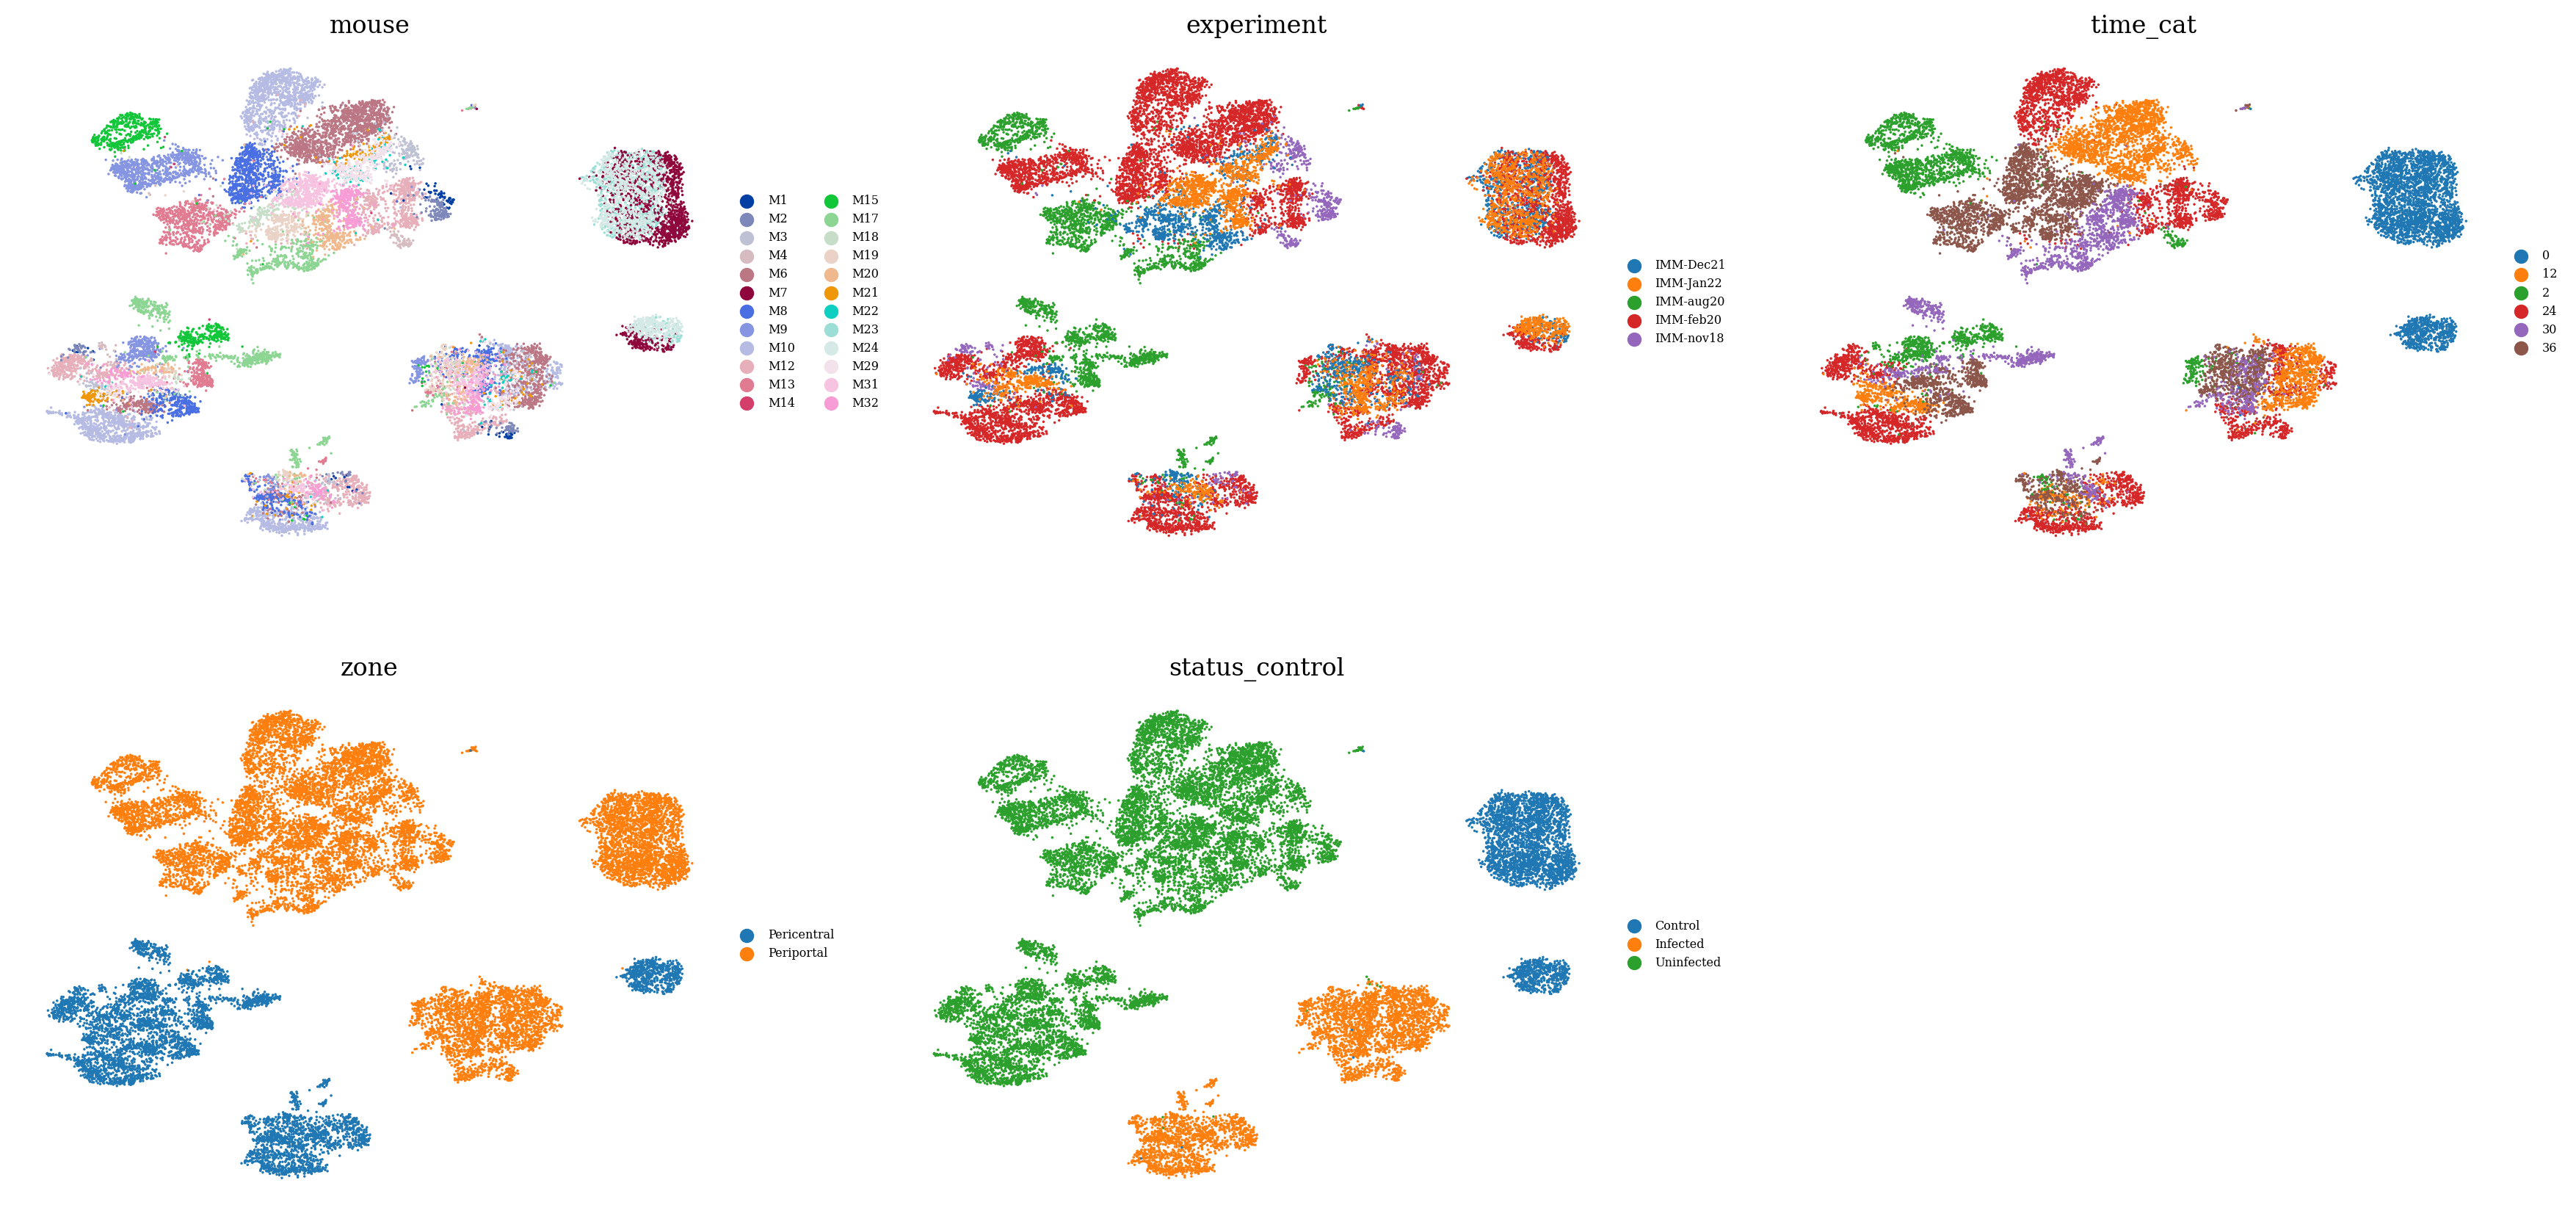

In [18]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

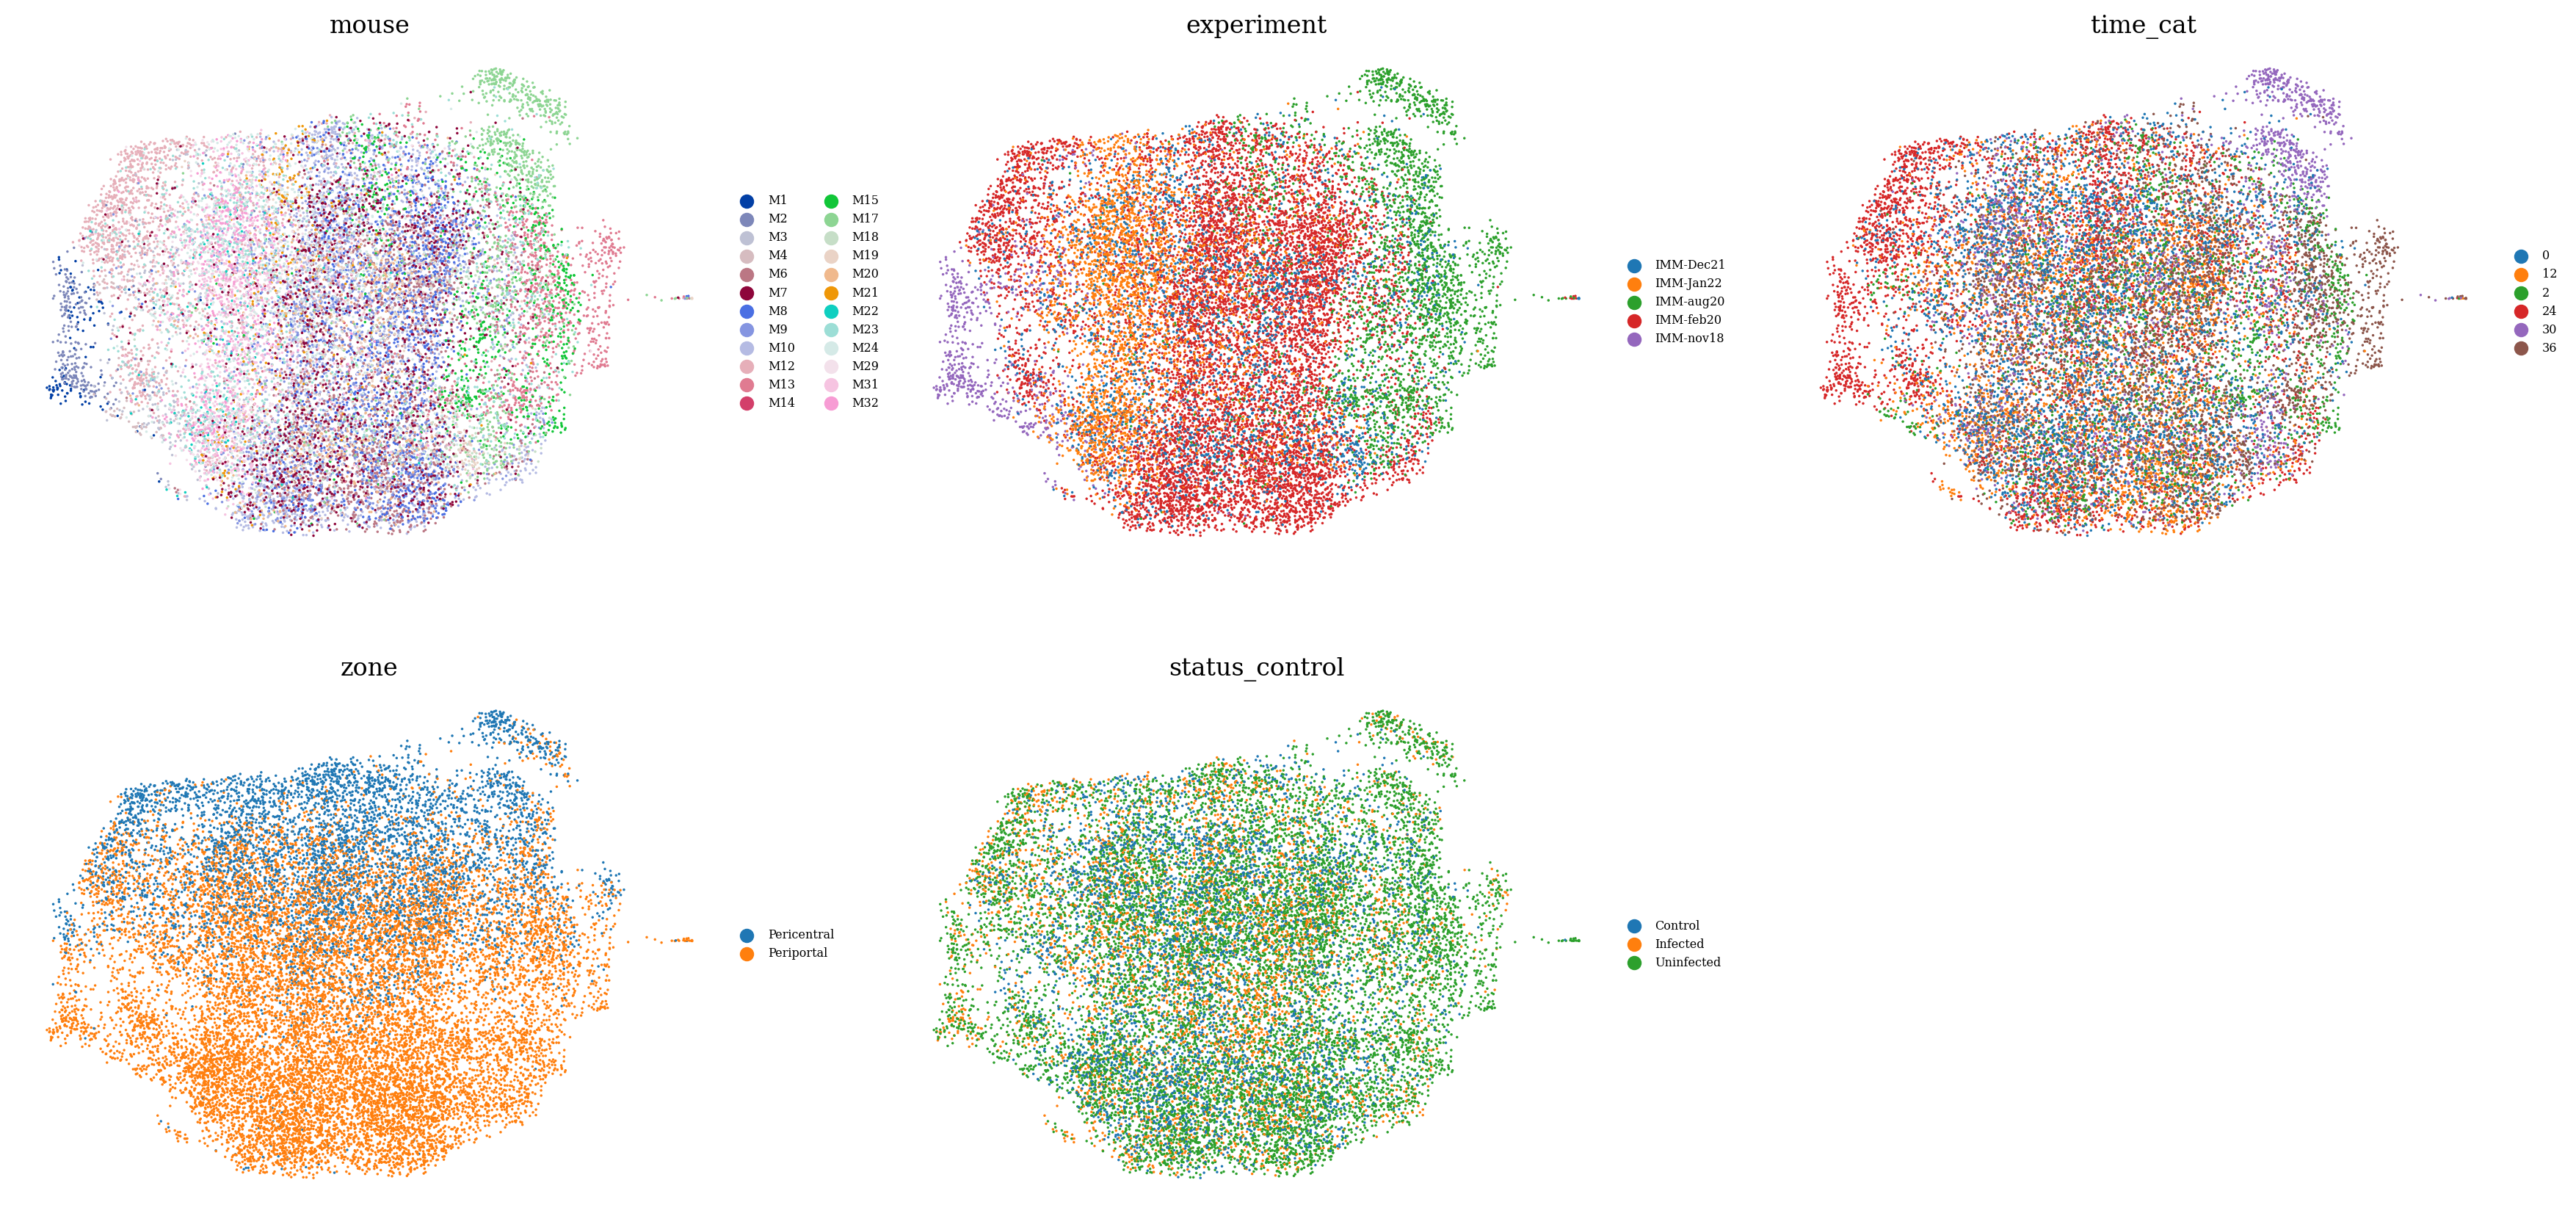

In [19]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [20]:
model.predict()

  0%|          | 0/596 [00:00<?, ?it/s]

  4%|▎         | 22/596 [00:00<00:02, 218.27it/s]

  8%|▊         | 47/596 [00:00<00:02, 231.38it/s]

 12%|█▏        | 72/596 [00:00<00:02, 238.64it/s]

 16%|█▋        | 98/596 [00:00<00:02, 244.30it/s]

 21%|██        | 123/596 [00:00<00:01, 245.31it/s]

 25%|██▍       | 148/596 [00:00<00:01, 241.47it/s]

 29%|██▉       | 173/596 [00:00<00:01, 243.64it/s]

 33%|███▎      | 198/596 [00:00<00:01, 245.20it/s]

 37%|███▋      | 223/596 [00:00<00:01, 243.29it/s]

 42%|████▏     | 248/596 [00:01<00:01, 243.15it/s]

 46%|████▌     | 273/596 [00:01<00:01, 244.40it/s]

 50%|█████     | 298/596 [00:01<00:01, 244.61it/s]

 54%|█████▍    | 323/596 [00:01<00:01, 242.46it/s]

 58%|█████▊    | 348/596 [00:01<00:01, 243.08it/s]

 63%|██████▎   | 373/596 [00:01<00:00, 243.66it/s]

 67%|██████▋   | 398/596 [00:01<00:00, 242.05it/s]

 71%|███████   | 423/596 [00:01<00:00, 241.11it/s]

 75%|███████▌  | 448/596 [00:01<00:00, 242.84it/s]

 79%|███████▉  | 473/596 [00:01<00:00, 242.89it/s]

 84%|████████▎ | 498/596 [00:02<00:00, 242.53it/s]

 88%|████████▊ | 523/596 [00:02<00:00, 242.54it/s]

 92%|█████████▏| 548/596 [00:02<00:00, 242.73it/s]

 96%|█████████▌| 573/596 [00:02<00:00, 241.38it/s]

100%|██████████| 596/596 [00:02<00:00, 242.09it/s]

In [21]:
pred_adata = adata[model.test_indices]
true = np.array(pred_adata.X)
pred = np.array(pred_adata.obsm["CPA_pred"])

In [22]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    print(start_ind, end_ind)
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind


0

32

32

64

64

96

In [23]:
np.mean(r2s)

0.9419738099374565

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)